In [ ]:
#| echo: false

%load_ext autoreload
%autoreload 2

Los torneos de Grand Slam no solo concentran el talento más alto del tenis profesional, sino que también implican una compleja logística con cientos de partidos, múltiples sedes y contratos televisivos que superan los 300 millones de dólares por edición. En ese contexto, anticipar con precisión la duración de cada encuentro es importante para organizar horarios de cancha, optimizar la parrilla de transmisiones y planear la recuperación de los jugadores. 

Este estudio se propone modelar y predecir la duración de los partidos masculinos disputados entre 1991 y 2022, comparando tres enfoques metodológicos: regresión lineal (OLS), modelos de árboles (Random Forest y XGBoost) y modelos lineales generalizados Gamma con enlace logarítmico.

Se construyeron cuatro versiones para cada tipo de modelo, incorporando progresivamente nuevas variables para evaluar la mejora en cada iteración. 

La regresión lineal OLS mostró una mejora modesta al incluir más variables, alcanzando su mejor resultado con un RMSE de 44.80 minutos y un R² de 0.055 en el conjunto de prueba. 

Este desempeño fue superado por los modelos de árboles, especialmente XGBoost, cuyo modelo completo logró reducir el RMSE a 44.81 minutos, aunque con signos claros de sobreajuste. Por su parte, el modelo Gamma destacó por su equilibrio entre precisión (RMSE: 44.98) y robustez (pseudo R²: 0.0574), siendo menos sensible al overfitting que los métodos de machine learning.

Las variables con mayor poder explicativo fueron la superficie de juego (particularmente el pasto, que reduce significativamente la duración), la diferencia de puntos en el ranking y el promedio de minutos jugados por los tenistas. Se validaron los supuestos de independencia en los modelos lineales y se aplicó un análisis de multicolinealidad para eliminar variables redundantes (VIF > 10). Aunque los modelos no incorporan factores como clima o lesiones, los resultados sugieren que es factible predecir la duración de los partidos con una precisión útil para aplicaciones operativas y comerciales en torneos de gran escala.

## Feature engineering

Para mejorar la capacidad predictiva de los modelos, se implementó un proceso sistemático de ingeniería de variables enfocado exclusivamente en partidos masculinos a cinco sets disputados en torneos de Grand Slam. Primero, se reetiquetaron los jugadores como *jugador_1* y *jugador_2* en función de sus puntos de ranking previos al partido, con el fin de garantizar consistencia en las estadísticas asociadas a cada rol. Luego, se crearon variables derivadas como la diferencia de ranking (`rank_diff`), edad (`age_diff`) y la cercanía competitiva (`close_ranking`), buscando capturar relaciones no lineales entre características individuales y duración del partido.

Posteriormente, se reformateó el dataset a un esquema centrado en el jugador para calcular promedios móviles de rendimiento —como aces, doble faltas, puntos ganados al servicio y duración de partidos— usando una ventana retrospectiva de cinco encuentros. Estas métricas fueron luego reagrupadas nuevamente a nivel de partido, distinguiendo entre el historial del `jugador_1` y del `jugador_2`. Este enfoque permitió incorporar conocimiento histórico del desempeño individual sin incurrir en *data leakage*, ya que toda información se construyó exclusivamente con partidos previos al observado. Finalmente, se eliminaron las estadísticas dentro del partido actual, así como identificadores y columnas textuales irrelevantes, asegurando que las variables finales fueran numéricas, informativas y compatibles con el entrenamiento de modelos supervisados.

## Feature selection

Una vez concluido el proceso de ingeniería de variables, se procedió a reducir dimensionalidad y eliminar redundancias mediante un análisis estadístico formal. Dado que muchas de las métricas generadas estaban correlacionadas entre sí —por ejemplo, estadísticas agregadas como `jugador_1_1stWon` o `avg_rank`—, era fundamental mitigar la multicolinealidad, especialmente para preservar la estabilidad de los modelos lineales y facilitar la interpretación de los coeficientes.

El criterio principal utilizado fue el Factor de Inflación de la Varianza (VIF), que mide cuánta varianza de una variable es explicada por el resto. Se calcularon los VIF únicamente para variables numéricas, y se eliminaron aquellas cuyo VIF superaba el umbral de 10, un valor estándar que indica colinealidad severa. Este análisis permitió conservar únicamente aquellas variables con contribución informativa no redundante, reduciendo el riesgo de sobreajuste y asegurando un conjunto parsimonioso para el modelado.

Como resultado de este filtrado, el conjunto final de variables utilizadas en los modelos se compuso únicamente por aquellas con bajo VIF y con relevancia teórica o empírica validada en etapas posteriores del análisis. Este conjunto formó la base del modelo completo (*full model*) utilizado en las tres familias de modelos predictivos.

## ETL

Realizamos un proceso de Extracción, Transformación y Carga (ETL) para preparar los datos de los partidos masculinos de Grand Slam entre 1991 y 2022. La extracción se llevó a cabo desde la base de datos de la ATP, que contiene información detallada sobre cada partido, incluyendo estadísticas individuales y del encuentro. Posteriormente, se transformaron los datos para unificar formatos, eliminar duplicados y corregir inconsistencias. Finalmente, los datos fueron cargados en un entorno adecuado para el análisis, asegurando que todas las variables estuvieran correctamente tipificadas y listas para su uso en modelos predictivos.

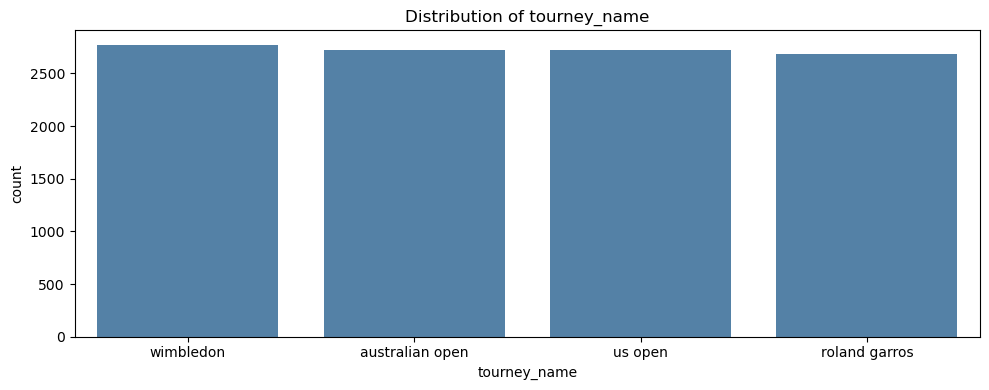

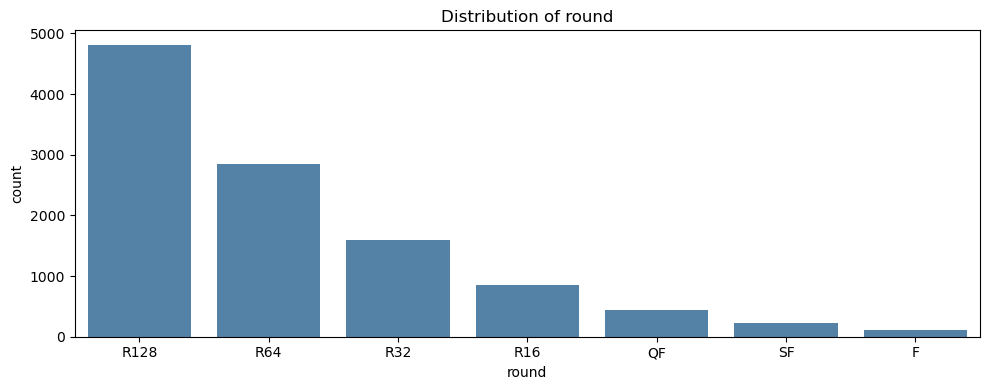

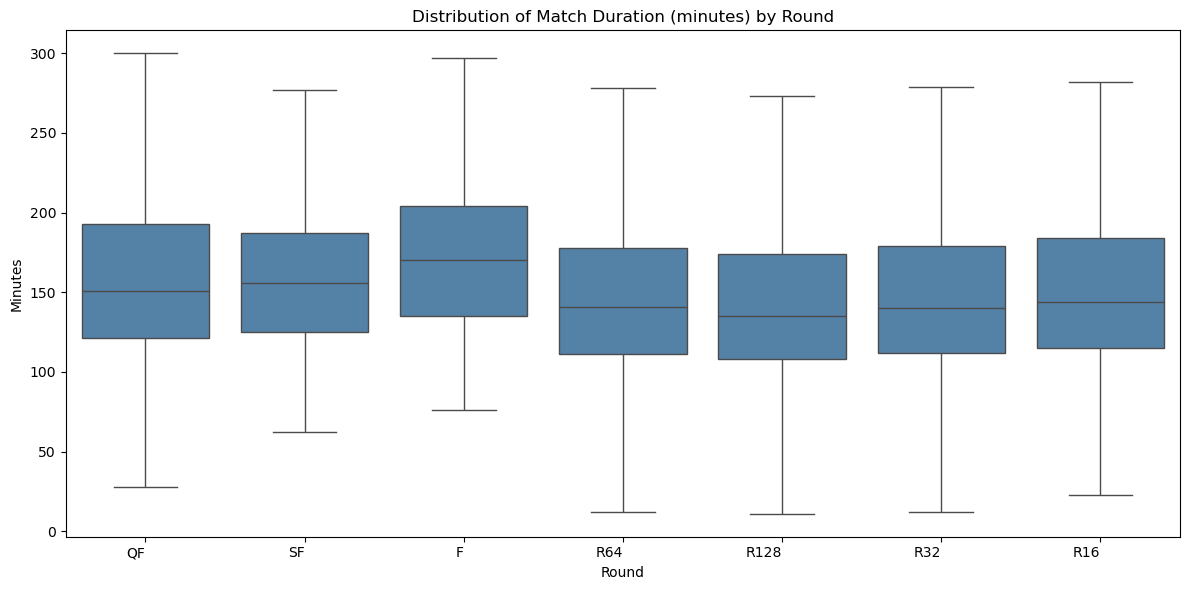

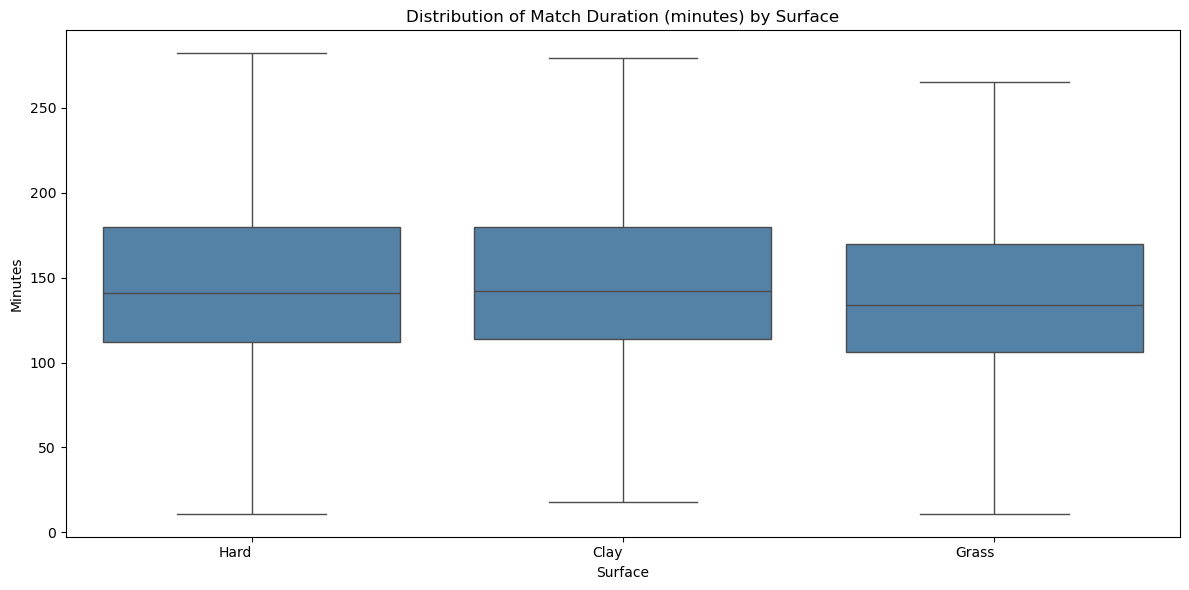

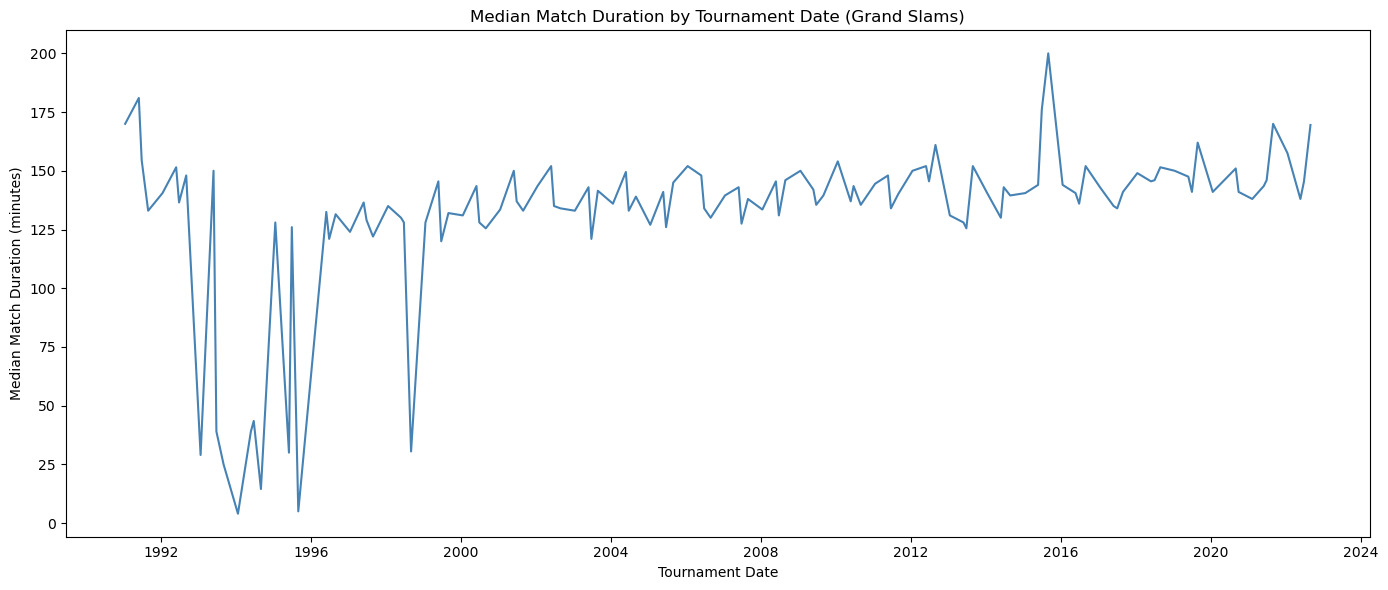

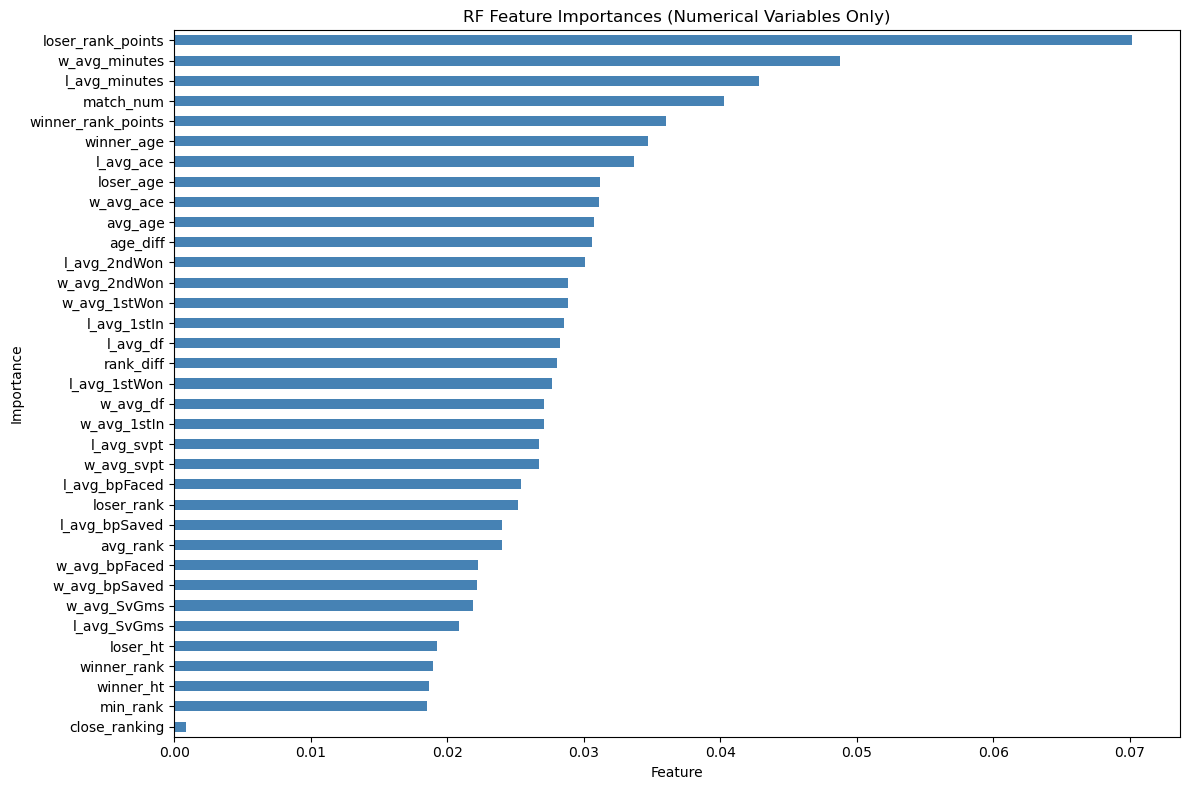

/Users/gerardoguerrero/miniforge3/envs/lineales/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



📊 VIF Scores (Numerical Features Only):
       feature  VIF
13     avg_age  inf
2   winner_age  inf
4    loser_age  inf
...
      feature       VIF
1   winner_ht  1.364780
3    loser_ht  1.331076
12   age_diff  1.041457

❌ Dropping high VIF features

✨ Tennis data analysis pipeline complete!
Final dataset shape: (10746, 18)


In [4]:
#| echo: false

from limpieza_with_min import main
file_path = "../atp_data/atp_matches_till_2022.csv"
final_data = main(file_path, show_plots=True)

In [ ]:
#| echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from scipy import stats
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec

In [ ]:
#| echo: false
pd.options.display.max_columns = 7

# --- Tu código para cargar y preparar 'preview' ---
# Asegúrate que la ruta es correcta y que pd está importado
df = pd.read_csv('../atp_data/final_tennis_data.csv') 
preview = df.head(10).copy() # Tomamos 10 para el preview, pero solo mostraremos 5
preview.rename(
    columns={
        'winner_ht':'p1_ht', 'loser_ht':'p2_ht',
        'winner_rank_points':'p1_rank_points', 'loser_rank_points':'p2_rank_points',
        'w_avg_ace':'p1_avg_ace', 'w_avg_df':'p1_avg_df', 'w_avg_minutes':'p1_avg_minutes',
        'l_avg_ace':'p2_avg_ace',
        'l_avg_df':'p2_avg_df', 
        'l_avg_minutes':'p2_avg_minutes'
    }, inplace=True
)
# --- Fin de tu código ---

# Simplemente deja que Quarto imprima el DataFrame (solo las primeras 5 filas)
preview.head(5)

p1_ht  p2_ht  p1_rank_points  ...  round_group_QF  round_group_SF  minutes
0  188.0  170.0          3889.0  ...             1.0             0.0     88.0
1  188.0  180.0          2541.0  ...             1.0             0.0    147.0
2  183.0  178.0           303.0  ...             1.0             0.0    204.0
3  190.0  190.0          3528.0  ...             1.0             0.0    111.0
4  188.0  188.0          2541.0  ...             0.0             1.0    242.0

[5 rows x 18 columns]

# Regresión Lineal

## Marco Teórico

La regresión lineal constituye un modelo paramétrico fundamental en estadística para analizar la relación entre una variable dependiente continua y un conjunto de variables independientes. Este modelo asume una relación lineal expresada mediante la ecuación $y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \cdots + \beta_p x_{ip} + \varepsilon_i$, donde los parámetros $\beta_0, \dots, \beta_p$ son estimados a través del método de mínimos cuadrados ordinarios (OLS), que minimiza la suma de residuos al cuadrado. El modelo mantiene su consistencia y eficiencia bajo los supuestos clásicos de linealidad en los parámetros, independencia de errores, homocedasticidad, ausencia de colinealidad perfecta y normalidad de los errores en contextos inferenciales.

In [46]:
#| echo: false

# Tabla de resultados de desempeño predictivo
metrics_data = {
    'Modelo': ['Modelo 1', 'Modelo 2', 'Modelo 3', 'Modelo 4'],
    'R2_train': [0.0477, 0.0506, 0.0613, 0.0644],
    'R2_test': [0.0377, 0.0419, 0.0518, 0.0550],
    'RMSE_train': [45.20, 45.13, 44.88, 44.80],
    'RMSE_test': [45.21, 45.11, 44.88, 44.80],
    'MAE_train': [36.62, 36.54, 36.37, 36.28],
    'MAE_test': [36.59, 36.53, 36.25, 36.19],
    'N_Variables': [7, 11, 9, 14]
}

df_metrics = pd.DataFrame(metrics_data)

coeff_data = [
    {'Modelo': 'Modelo 1', 'Variable': 'surface_Grass',    'Coeficiente': -9.13, 'Interpretacion': 'Los partidos en pasto duran 9.13 min menos'},
    {'Modelo': 'Modelo 1', 'Variable': 'surface_Hard',     'Coeficiente': -2.31, 'Interpretacion': 'La superficie dura reduce la duración en 2.31 min'},
    {'Modelo': 'Modelo 1', 'Variable': 'round_group_SF',   'Coeficiente':  0.90, 'Interpretacion': 'Las semifinales incrementan la duración en 0.90 min'},
    {'Modelo': 'Modelo 2', 'Variable': 'round_group_SF',   'Coeficiente':  1.36, 'Interpretacion': 'Aumento mayor al incorporar estadísticas de jugador'},
    {'Modelo': 'Modelo 2', 'Variable': 'surface_Grass',    'Coeficiente': -9.12, 'Interpretacion': 'Se mantiene el efecto de superficie'},
    {'Modelo': 'Modelo 3', 'Variable': 'round_group_SF',   'Coeficiente':  2.17, 'Interpretacion': 'Aumenta al incluir minutos históricos'},
    {'Modelo': 'Modelo 3', 'Variable': 'surface_Grass',    'Coeficiente': -8.59, 'Interpretacion': 'Efecto consistente de reducción'},
    {'Modelo': 'Modelo 4', 'Variable': 'surface_Grass',    'Coeficiente': -8.41, 'Interpretacion': 'Superficie sigue siendo el factor más influyente'},
    {'Modelo': 'Modelo 4', 'Variable': 'round_group_SF',   'Coeficiente':  2.61, 'Interpretacion': 'Aumenta la duración respecto a rondas anteriores'},
    {'Modelo': 'Modelo 4', 'Variable': 'round_group_Other','Coeficiente': -1.66, 'Interpretacion': 'Rondas iniciales tienen menor duración'},
]

df_coeff = pd.DataFrame(coeff_data)


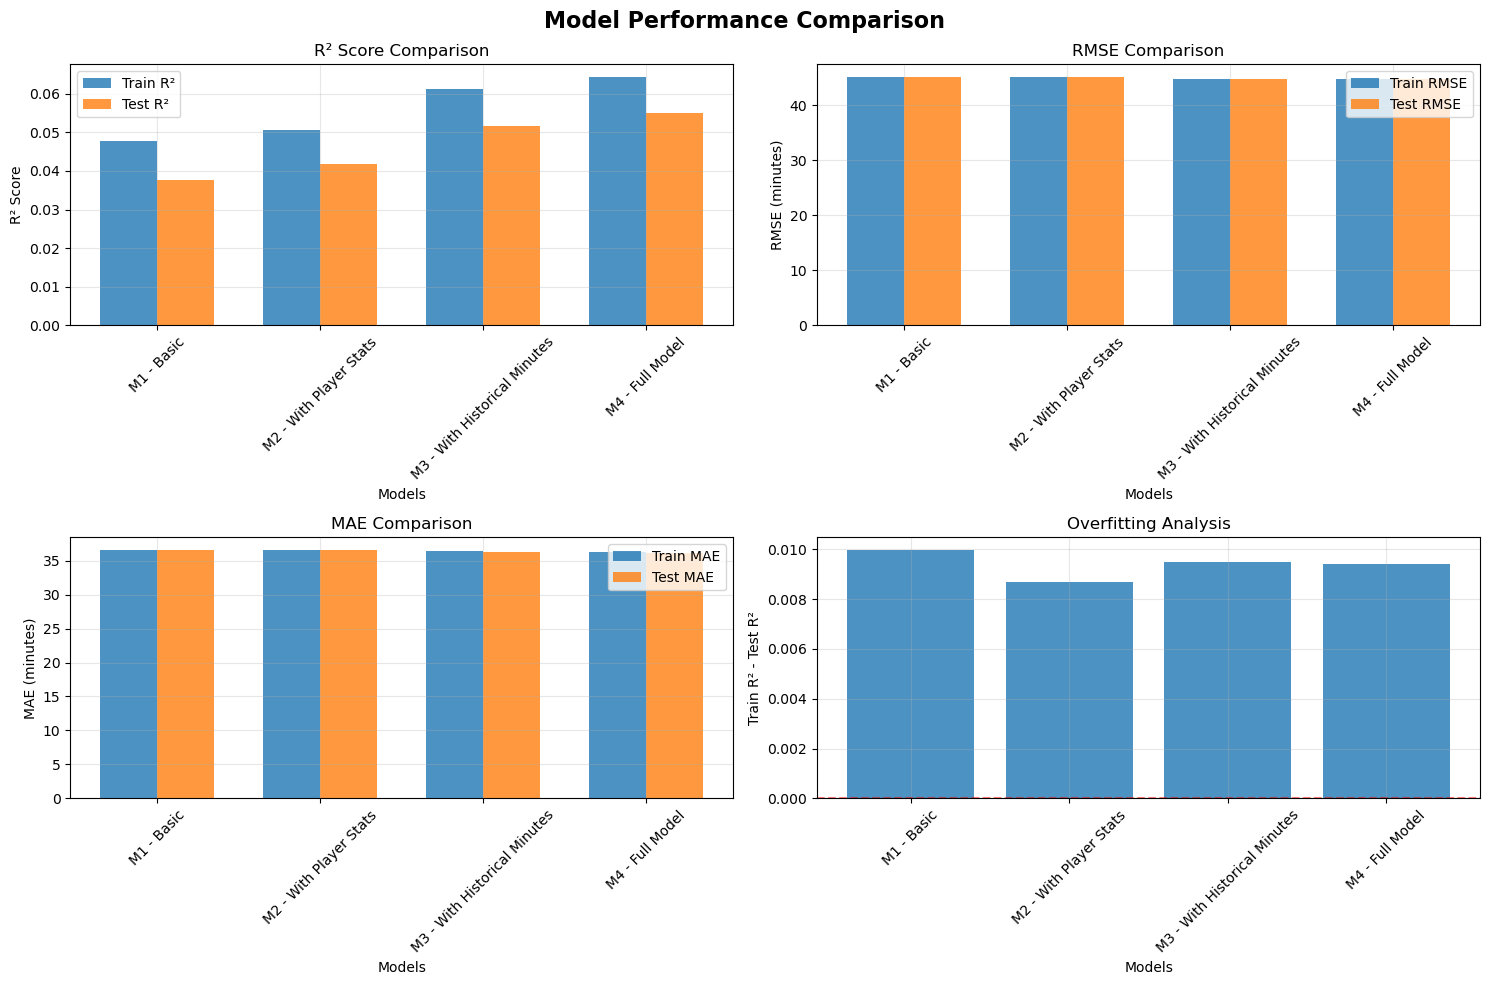

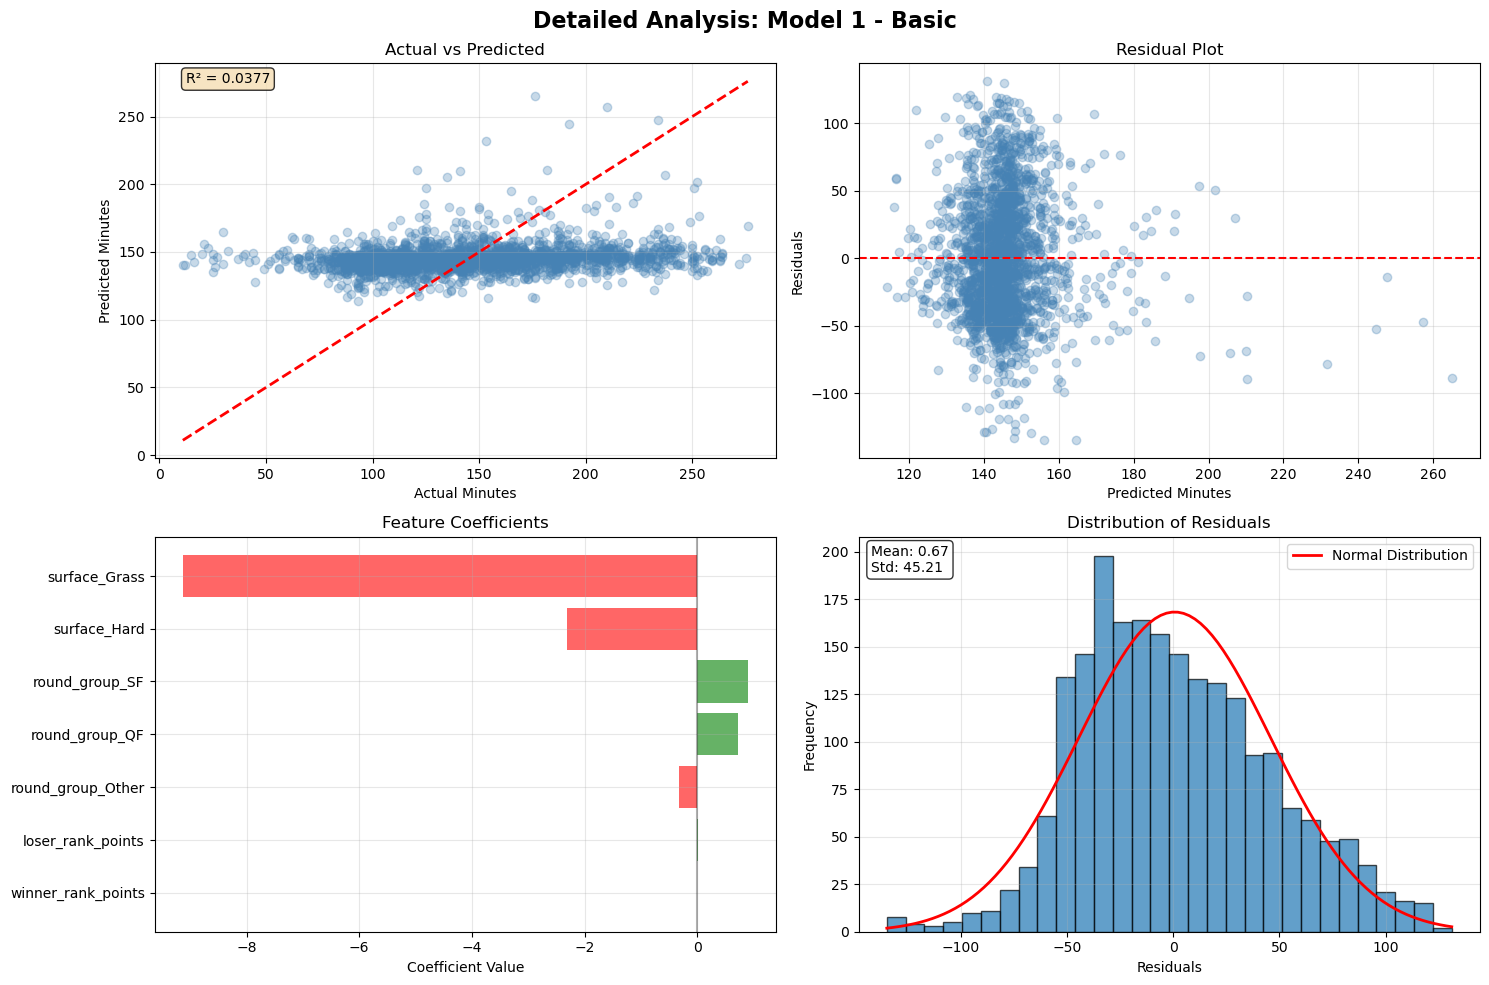

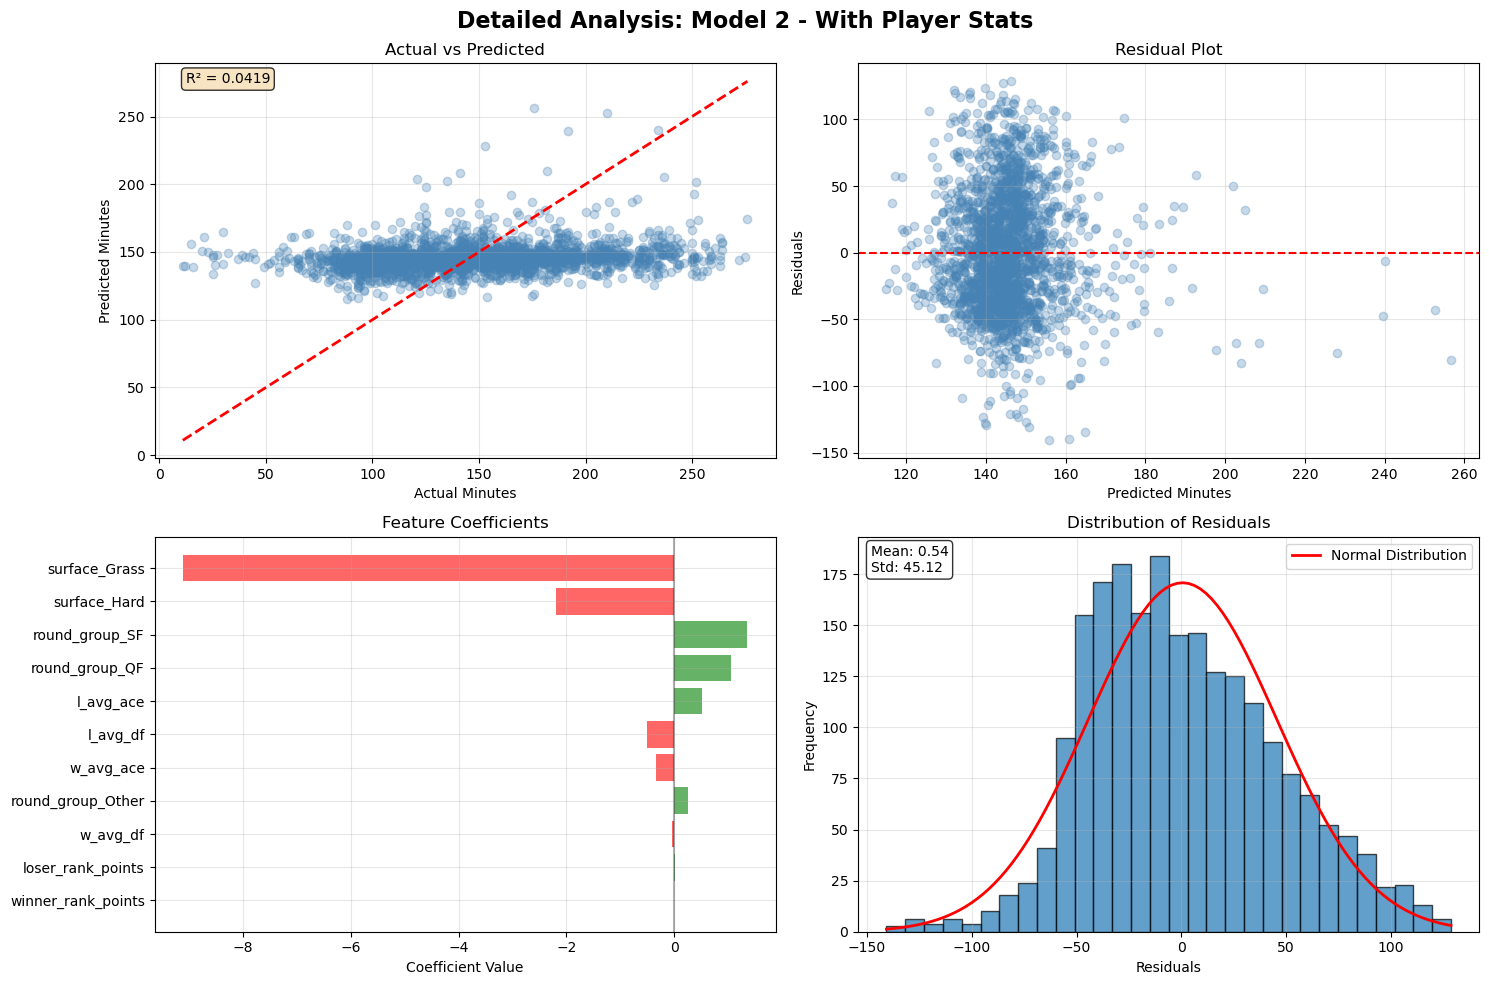

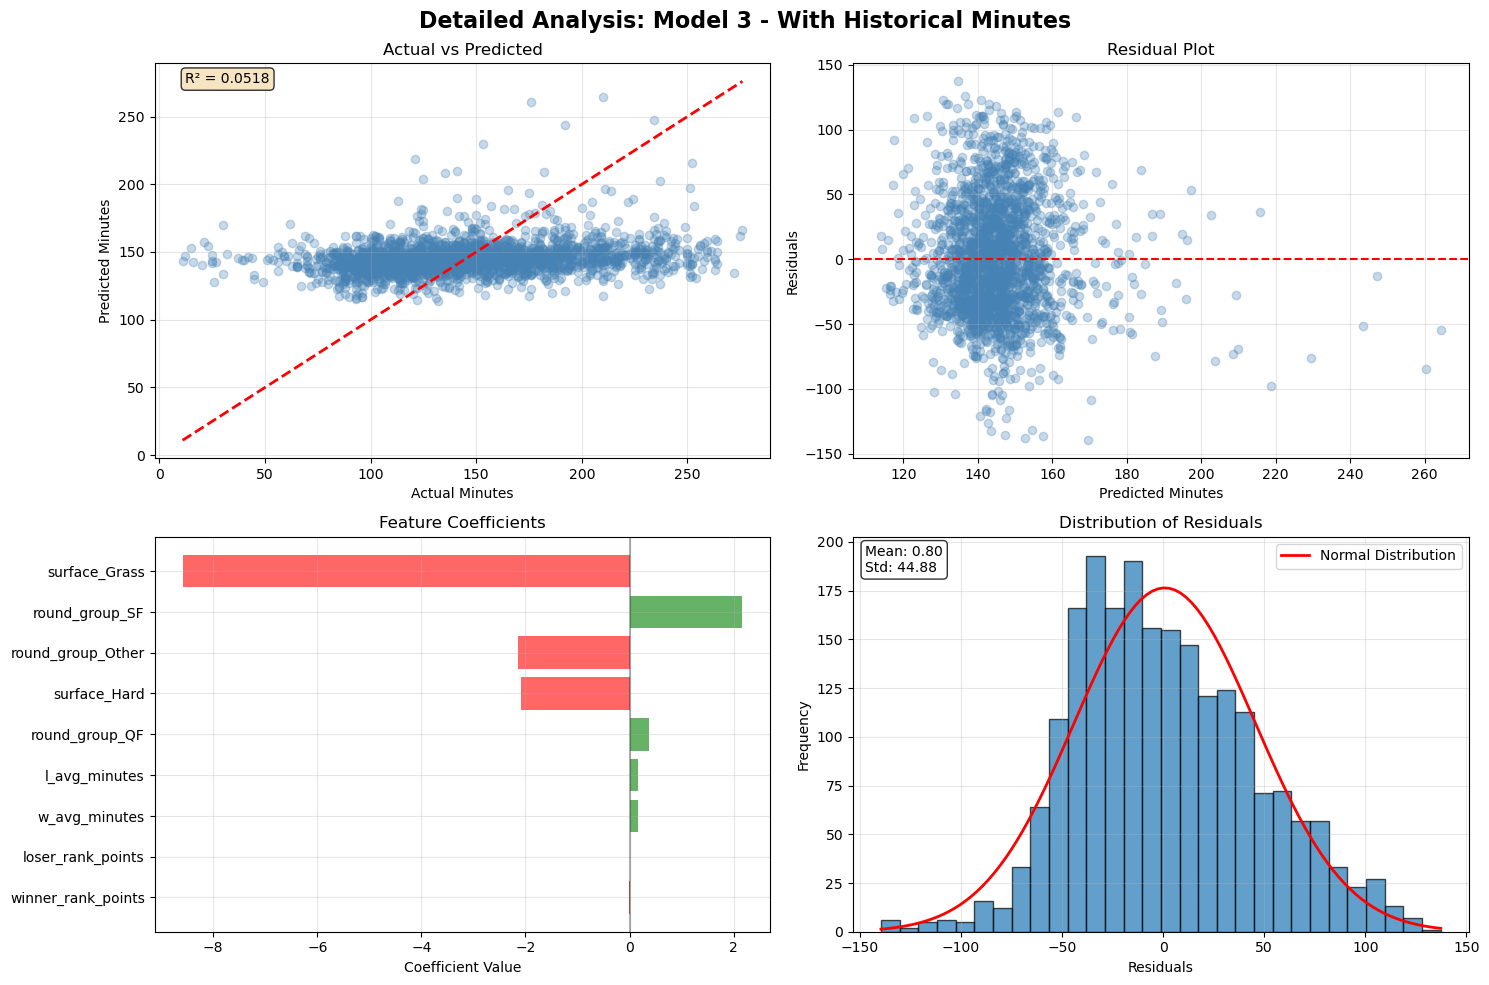

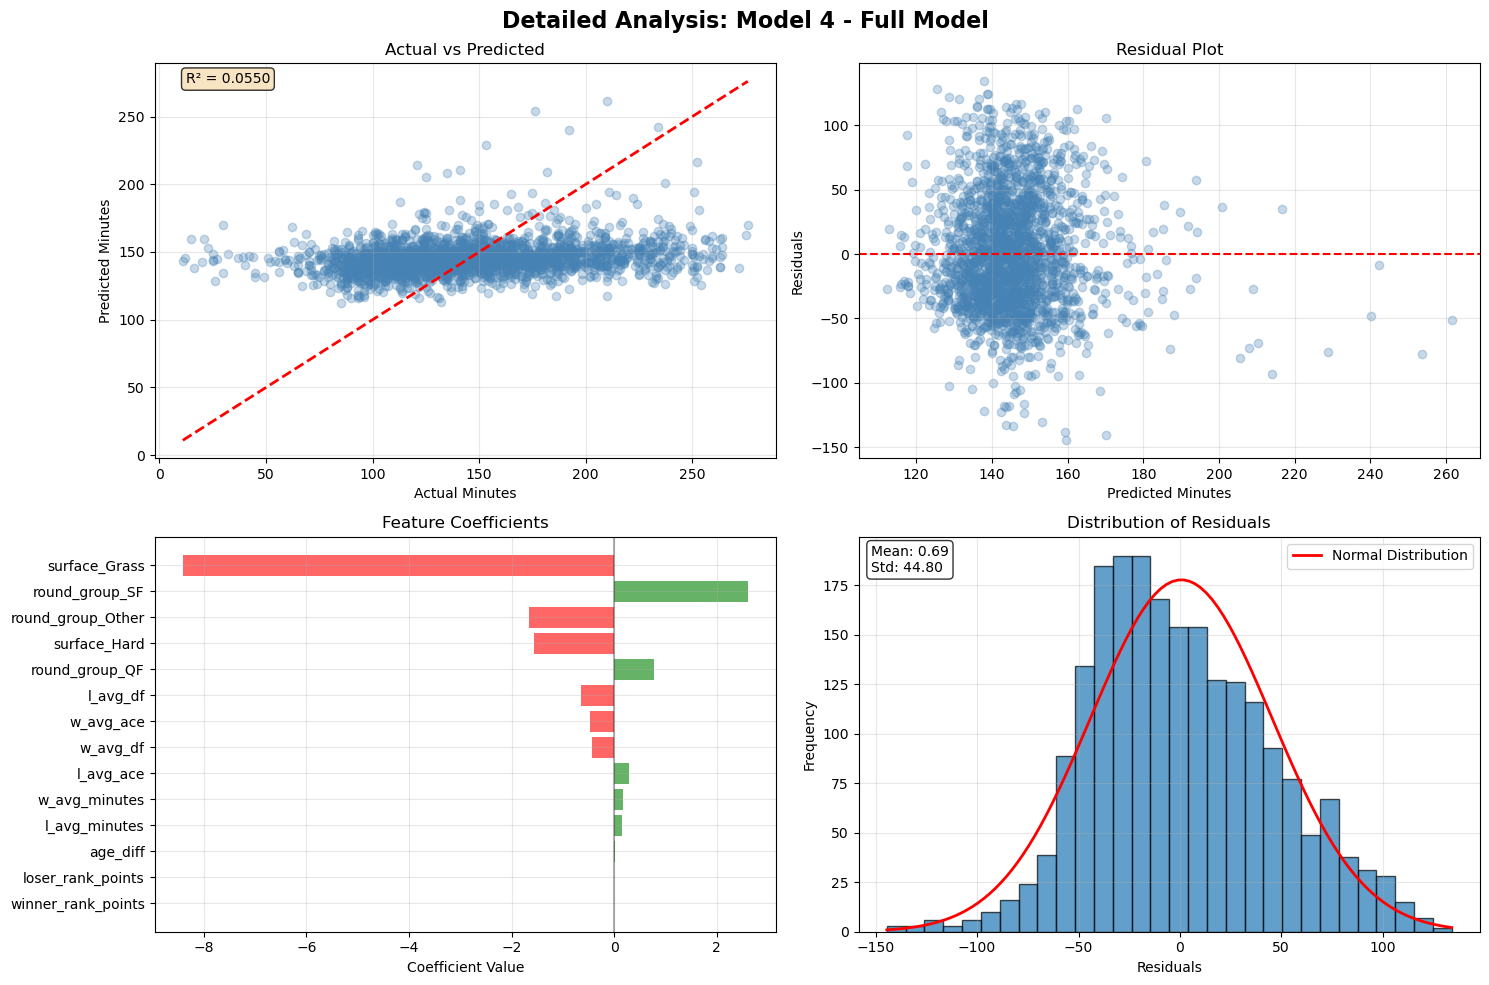

In [ ]:
#| echo: false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
#sns.set_palette("husl")

# Asume que df_clean es tu DataFrame
# df_clean = tu_dataframe_aqui

def create_regression_models(df):
    """
    Crea y compara múltiples modelos de regresión lineal.
    """
    
    # Define diferentes conjuntos de características
    models = {
        'Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                       'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                       'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                            'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                            'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Variable objetivo
    y = df['minutes']
    
    # Almacenar resultados
    results = {}
    trained_models = {}
    test_data = {}  # Almacenar datos de prueba para cada modelo
    
    # Dividir datos una vez para una comparación consistente (no se usa y_test_basic directamente pero mantiene la lógica)
    X_basic = df[models['Model 1 - Basic']]
    _, _, _, _ = train_test_split(X_basic, y, test_size=0.2, random_state=42)
    
    for model_name, features in models.items():
        # Preparar datos para este modelo específico
        X = df[features]
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Almacenar datos de prueba para uso posterior
        test_data[model_name] = {'X_test': X_test, 'y_test': y_test_model}
        
        # Crear y entrenar modelo
        model = LinearRegression()
        model.fit(X_train, y_train_model)
        
        # Predicciones
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Métricas
        train_r2 = r2_score(y_train_model, y_pred_train)
        test_r2 = r2_score(y_test_model, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
        train_mae = mean_absolute_error(y_train_model, y_pred_train)
        test_mae = mean_absolute_error(y_test_model, y_pred_test)
        
        # Almacenar resultados
        results[model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': features,
            'coefficients': model.coef_,
            'intercept': model.intercept_
        }
        
        trained_models[model_name] = model
        
    return results, trained_models, test_data

def plot_model_comparison(results):
    """
    Crea gráficos de comparación para todos los modelos.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models_keys = list(results.keys())
    
    # Comparación R²
    train_r2 = [results[model]['train_r2'] for model in models_keys]
    test_r2 = [results[model]['test_r2'] for model in models_keys]
    
    x = np.arange(len(models_keys))
    width = 0.35
    
    axes[0,0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8,color = 'C0')
    axes[0,0].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8, color = 'C1')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('Model ', 'M') for m in models_keys], rotation=45)
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Comparación RMSE
    train_rmse = [results[model]['train_rmse'] for model in models_keys]
    test_rmse = [results[model]['test_rmse'] for model in models_keys]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color = 'C0')
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color = 'C1')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('Model ', 'M') for m in models_keys], rotation=45)
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Comparación MAE
    train_mae = [results[model]['train_mae'] for model in models_keys]
    test_mae = [results[model]['test_mae'] for model in models_keys]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8, color = 'C0')
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8, color = 'C1')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('Model ', 'M') for m in models_keys], rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Análisis de sobreajuste (Train R² - Test R²)
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models_keys]
    
    axes[1,1].bar(models_keys, overfitting, alpha=0.8, color='C0')
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticklabels([m.replace('Model ', 'M') for m in models_keys], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

def plot_detailed_model_analysis(model_name, results, trained_models, test_data, df):
    """
    Análisis detallado de un modelo específico (solo gráficos).
    """
    
    model = trained_models[model_name]
    features = results[model_name]['features']
    
    # Obtener los datos de prueba correctos para este modelo
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    
    # Predicciones
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Detailed Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    # Real vs Predicho
    axes[0,0].scatter(y_test, y_pred, alpha=0.3, color='steelblue')
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    # Añadir R² al gráfico
    r2 = r2_score(y_test, y_pred)
    axes[0,0].text(0.05, 0.95, f'R² = {r2:.4f}', transform=axes[0,0].transAxes, 
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    # Residuos
    residuals = y_test - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.3, color='steelblue')
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted Minutes')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    # Importancia de características (coeficientes)
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_
    }).sort_values('Coefficient', key=abs, ascending=True)
    
    colors = ['red' if x < 0 else 'green' for x in coef_df['Coefficient']]
    axes[1,0].barh(coef_df['Feature'], coef_df['Coefficient'], color=colors, alpha=0.6)
    axes[1,0].set_xlabel('Coefficient Value')
    axes[1,0].set_title('Feature Coefficients')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Distribución de residuos
    axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='C0')
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    mu, sigma = residuals.mean(), residuals.std()
    x_norm = np.linspace(residuals.min(), residuals.max(), 100)
    axes[1,1].plot(x_norm, len(residuals) * (residuals.max() - residuals.min()) / 30 * (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_norm - mu) / sigma) ** 2),
                   'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    axes[1,1].text(0.02, 0.98, f'Mean: {mu:.2f}\nStd: {sigma:.2f}', 
                   transform=axes[1,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_models_detailed_analysis(results, trained_models, test_data, df):
    """
    Muestra análisis detallado (gráficos) para todos los modelos.
    """
    for model_name in results.keys():
        plot_detailed_model_analysis(model_name, results, trained_models, test_data, df)

def determine_best_model_name(results):
    """
    Determina el mejor modelo basado en R² de prueba (sin imprimir).
    """
    if not results:
        return None
    best_model = max(results.items(), key=lambda x: x[1]['test_r2'])
    best_name, _ = best_model
    return best_name

def run_complete_analysis(df):
    """
    Ejecuta el análisis de regresión completo y muestra los gráficos.
    """
    results, trained_models, test_data = create_regression_models(df)
    plot_model_comparison(results)
    _ = determine_best_model_name(results) # El nombre del mejor modelo se determina pero no se imprime
    plot_all_models_detailed_analysis(results, trained_models, test_data, df)
    return results, trained_models, test_data # Devuelve test_data también

def run_analysis_single_model(df, model_name=None):
    """
    Ejecuta análisis para un modelo específico (gráficos) o devuelve objetos de modelo.
    Devuelve results, trained_models, y test_data.
    """
    results, trained_models, test_data = create_regression_models(df)
    
    if model_name is None:
        # No se realizan gráficos automáticamente si no se especifica el nombre del modelo.
        # El usuario puede usar los objetos devueltos para graficar manualmente.
        pass
    elif model_name in results:
        plot_detailed_model_analysis(model_name, results, trained_models, test_data, df)
    else:
        # Nombre de modelo no encontrado, no hace nada silenciosamente.
        pass
    
    return results, trained_models, test_data

# --- INSTRUCCIONES DE USO ---
# Asegúrate de que tu DataFrame 'df_clean' esté cargado y preprocesado antes de llamar a estas funciones.

# Ejemplo de cómo podrías llamar a las funciones:

# OPCIÓN 1: Análisis completo con gráficos detallados de TODOS los modelos
# (Asegúrate de que 'df_clean' esté definido con tus datos)
results, models, t_data = run_complete_analysis(df_clean)

# OPCIÓN 2: Análisis para un modelo específico (solo gráficos de ese modelo)
# (Asegúrate de que 'df_clean' esté definido con tus datos)
# results, models, t_data = run_analysis_single_model(df_clean, 'Model 4 - Full Model')

# OPCIÓN 3: Obtener los resultados y objetos de modelo, luego decidir qué graficar manualmente
# (Asegúrate de que 'df_clean' esté definido con tus datos)
# results, models, t_data = run_analysis_single_model(df_clean)
#
# Si usaste la OPCIÓN 3 y quieres ver los gráficos de un modelo específico después:
# if results and 'Model 1 - Basic' in results:
#    plot_detailed_model_analysis('Model 1 - Basic', results, models, t_data, df_clean)
#
# O para ver la comparación general de modelos:
# if results:
#    plot_model_comparison(results)

# Los nombres de modelo disponibles (si necesitas referenciarlos) son:
# 'Model 1 - Basic'
# 'Model 2 - With Player Stats'
# 'Model 3 - With Historical Minutes'
# 'Model 4 - Full Model'

### Análisis de Resultados
En el presente estudio se implementaron cuatro configuraciones progresivas del modelo OLS para evaluar la capacidad predictiva en la duración de partidos de tenis. El Modelo 1 incorpora variables básicas como superficie del torneo, etapa del torneo y puntos de ranking de los jugadores. El Modelo 2 añade estadísticas de desempeño promedio incluyendo aces y dobles faltas. El Modelo 3 integra la duración promedio histórica de partidos por jugador, mientras que el Modelo 4 representa la configuración completa con todas las variables seleccionadas tras el análisis de multicolinealidad. Los resultados revelan que todos los modelos presentan valores de considerablemente bajos, con el modelo más completo explicando únicamente el 5.5% de la varianza en el conjunto de prueba, indicando una capacidad explicativa limitada pero con mejoras progresivas en las métricas de error conforme se incorporan variables adicionales.

#### Resultados de Desempeño Predictivo


In [48]:
#| echo: false
pd.options.display.max_columns = 8
df_metrics

Modelo  R2_train  R2_test  RMSE_train  RMSE_test  MAE_train  MAE_test  \
0  Modelo 1    0.0477   0.0377       45.20      45.21      36.62     36.59   
1  Modelo 2    0.0506   0.0419       45.13      45.11      36.54     36.53   
2  Modelo 3    0.0613   0.0518       44.88      44.88      36.37     36.25   
3  Modelo 4    0.0644   0.0550       44.80      44.80      36.28     36.19   

   N_Variables  
0            7  
1           11  
2            9  
3           14

#### Coeficientes Más Relevantes e Interpretación

In [49]:
#| echo: false
df_coeff

Modelo           Variable  Coeficiente  \
0  Modelo 1      surface_Grass        -9.13   
1  Modelo 1       surface_Hard        -2.31   
2  Modelo 1     round_group_SF         0.90   
3  Modelo 2     round_group_SF         1.36   
4  Modelo 2      surface_Grass        -9.12   
5  Modelo 3     round_group_SF         2.17   
6  Modelo 3      surface_Grass        -8.59   
7  Modelo 4      surface_Grass        -8.41   
8  Modelo 4     round_group_SF         2.61   
9  Modelo 4  round_group_Other        -1.66   

                                      Interpretacion  
0         Los partidos en pasto duran 9.13 min menos  
1  La superficie dura reduce la duración en 2.31 min  
2  Las semifinales incrementan la duración en 0.9...  
3  Aumento mayor al incorporar estadísticas de ju...  
4                Se mantiene el efecto de superficie  
5              Aumenta al incluir minutos históricos  
6                    Efecto consistente de reducción  
7   Superficie sigue siendo el factor más influyente  
8   Aumenta la duración respecto a rondas anteriores  
9             Rondas iniciales tienen menor duración

El análisis empírico demuestra que la regresión lineal, aun en su configuración más comprehensiva, mantiene una capacidad explicativa limitada coherente con la naturaleza multifactorial inherente a la duración de partidos de tenis, donde influyen variables no observadas como estilos de juego, condiciones climáticas y eventos fortuitos. No obstante, el examen de coeficientes revela patrones sistemáticamente significativos, particularmente el efecto de la superficie de juego, donde los partidos en césped presentan duraciones considerablemente menores, consistente con la dinámica de menor intercambio característica de esta superficie. Las semifinales y finales exhiben incrementos sostenidos en duración, atribuibles a la mayor paridad competitiva en etapas decisivas. Metodológicamente, la regresión lineal demuestra utilidad como modelo base proporcionando transparencia interpretativa y evaluación de relaciones marginales entre variables, estableciendo un benchmark fundamental para la validación de modelos no lineales más complejos, a pesar de su desempeño predictivo comparativamente limitado.

# XG Boost
## Marco Teórico

XGBoost (eXtreme Gradient Boosting) es un algoritmo de aprendizaje supervisado basado en el principio de *gradient boosting*, diseñado para maximizar tanto la precisión predictiva como la eficiencia computacional. A diferencia de los modelos paramétricos clásicos, XGBoost construye de manera aditiva un conjunto (ensamble) de árboles de decisión, de forma que cada nuevo árbol corrige los errores residuales cometidos por el conjunto previo. Formalmente, la predicción para la observación $i$ en la iteración $m$ se expresa como

$$
\hat{y}_i^{(m)} = \sum_{k=1}^m f_k(x_i)\,,
$$

donde cada $f_k$ es un árbol de decisión que mapea el vector de características $x_i$ a un valor real. El objetivo es minimizar una función de pérdida penalizada sobre todo el ensamble:

$$
\mathcal{L} = \sum_{i=1}^n \ell\bigl(y_i,\hat{y}_i^{(m)}\bigr) \;+\; \sum_{k=1}^m \Omega(f_k)\,.
$$

Aquí, $\ell$ es una medida de error y $\Omega(f)$ es un término de regularización que controla la complejidad de cada árbol:

$$
\Omega(f) = \gamma T + \tfrac{1}{2} \lambda \sum_{j=1}^T w_j^2,
$$

donde $T$ es el número de hojas del árbol y $w_j$ el valor de predicción en la hoja $j$. Los hiperparámetros $\gamma$ y $\lambda$ permiten penalizar tanto el tamaño del árbol como la magnitud de sus valores terminales, favoreciendo modelos más simples y reduciendo el riesgo de sobreajuste.

Para optimizar $\mathcal{L}$, XGBoost utiliza una aproximación de segundo orden mediante series de Taylor, calculando en cada paso las derivadas primera $(g_i$)$ y segunda $(h_i)$ de la pérdida respecto a la predicción actual:

$$
g_i = \frac{\partial \ell(y_i, \hat{y}_i)}{\partial \hat{y}_i}, \quad
h_i = \frac{\partial^2 \ell(y_i, \hat{y}_i)}{\partial \hat{y}_i^2}
$$

Con estos residuos gradiente y hessiano, el algoritmo evalúa de manera eficiente el beneficio de dividir cada posible nodo del árbol, escogiendo la partición que maximiza la reducción de la función objetivo regularizada. Además, XGBoost incorpora mecanismos como shrinkage , muestreo de filas y columnas subsample,colsample_bytree, y poda de ramas con ganancia negativa, lo que mejora aún más la generalización y la velocidad de convergencia.

En el plano de la implementación, XGBoost está altamente optimizado para aprovechar arquitecturas modernas: emplea técnicas de aprendizaje por bloques en memoria, algoritmos de búsqueda de cortes aproximados, soporte para entrenamiento paralelo y procesamiento out-of-core cuando los datos exceden la memoria RAM. También maneja de forma nativa valores faltantes, aprendiendo automáticamente la mejor ruta para cada registro con ausencia de datos en una característica determinada.


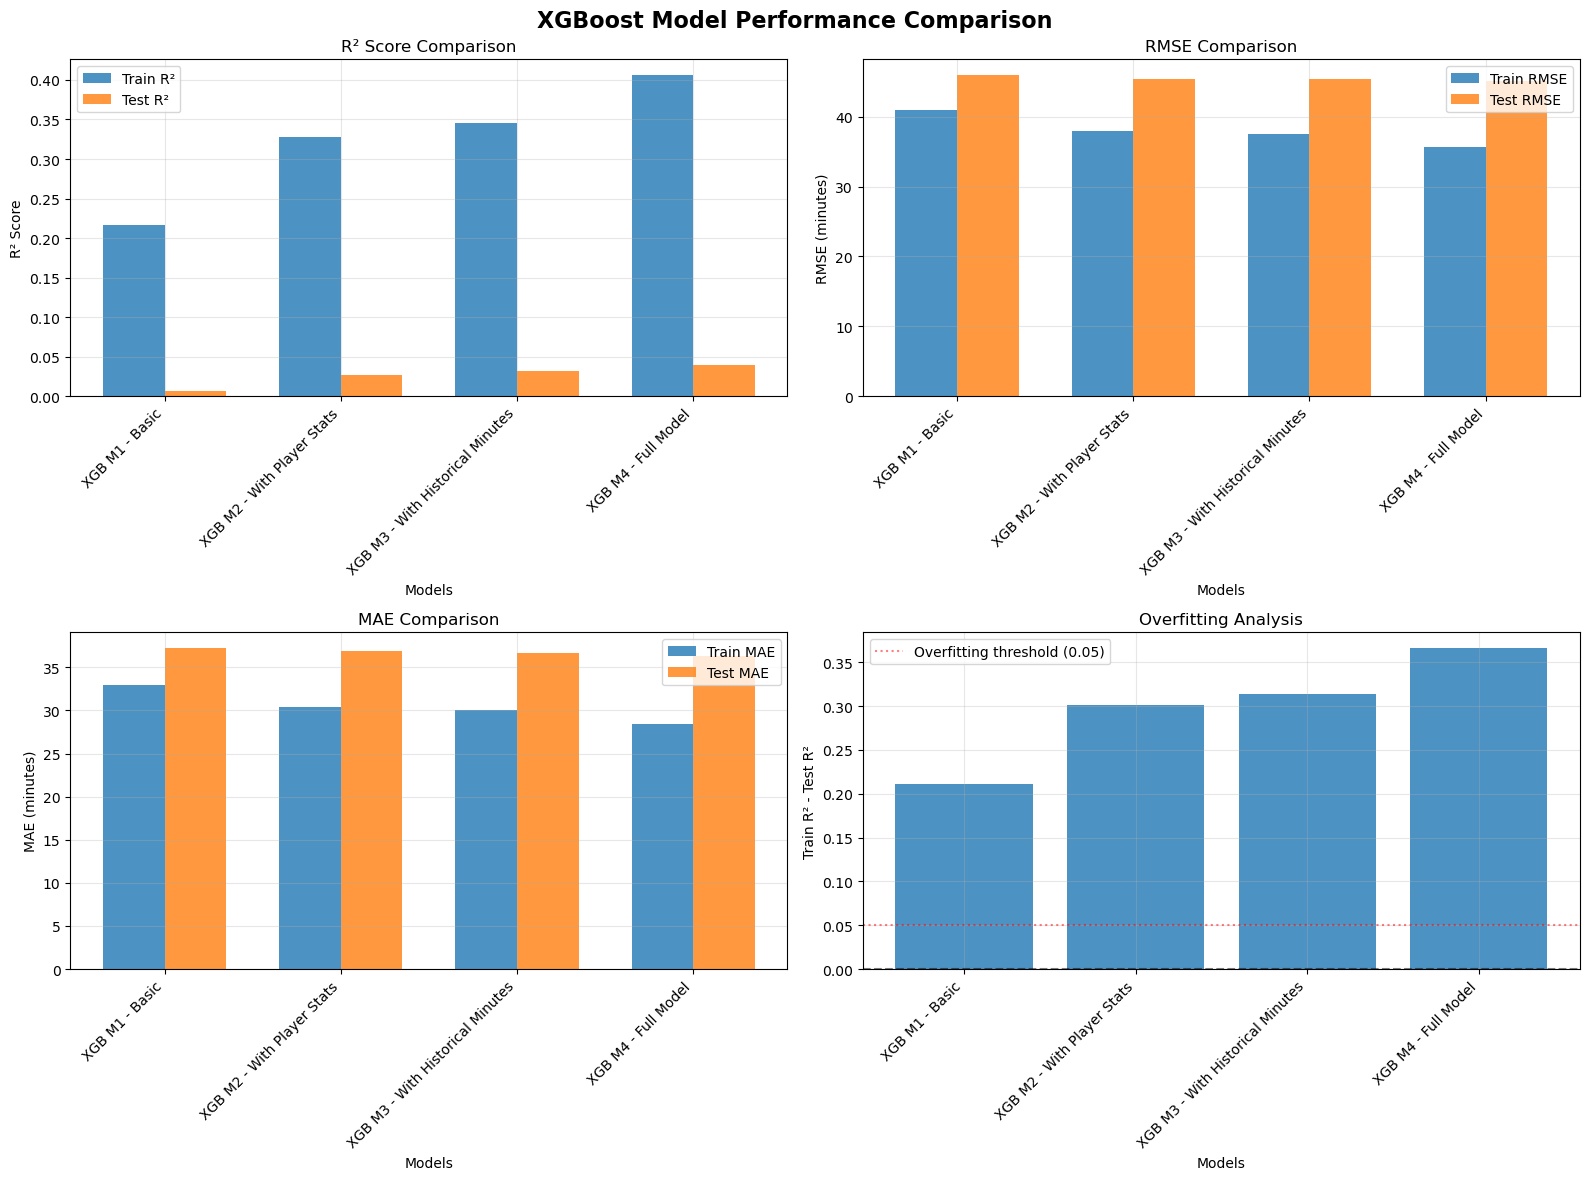

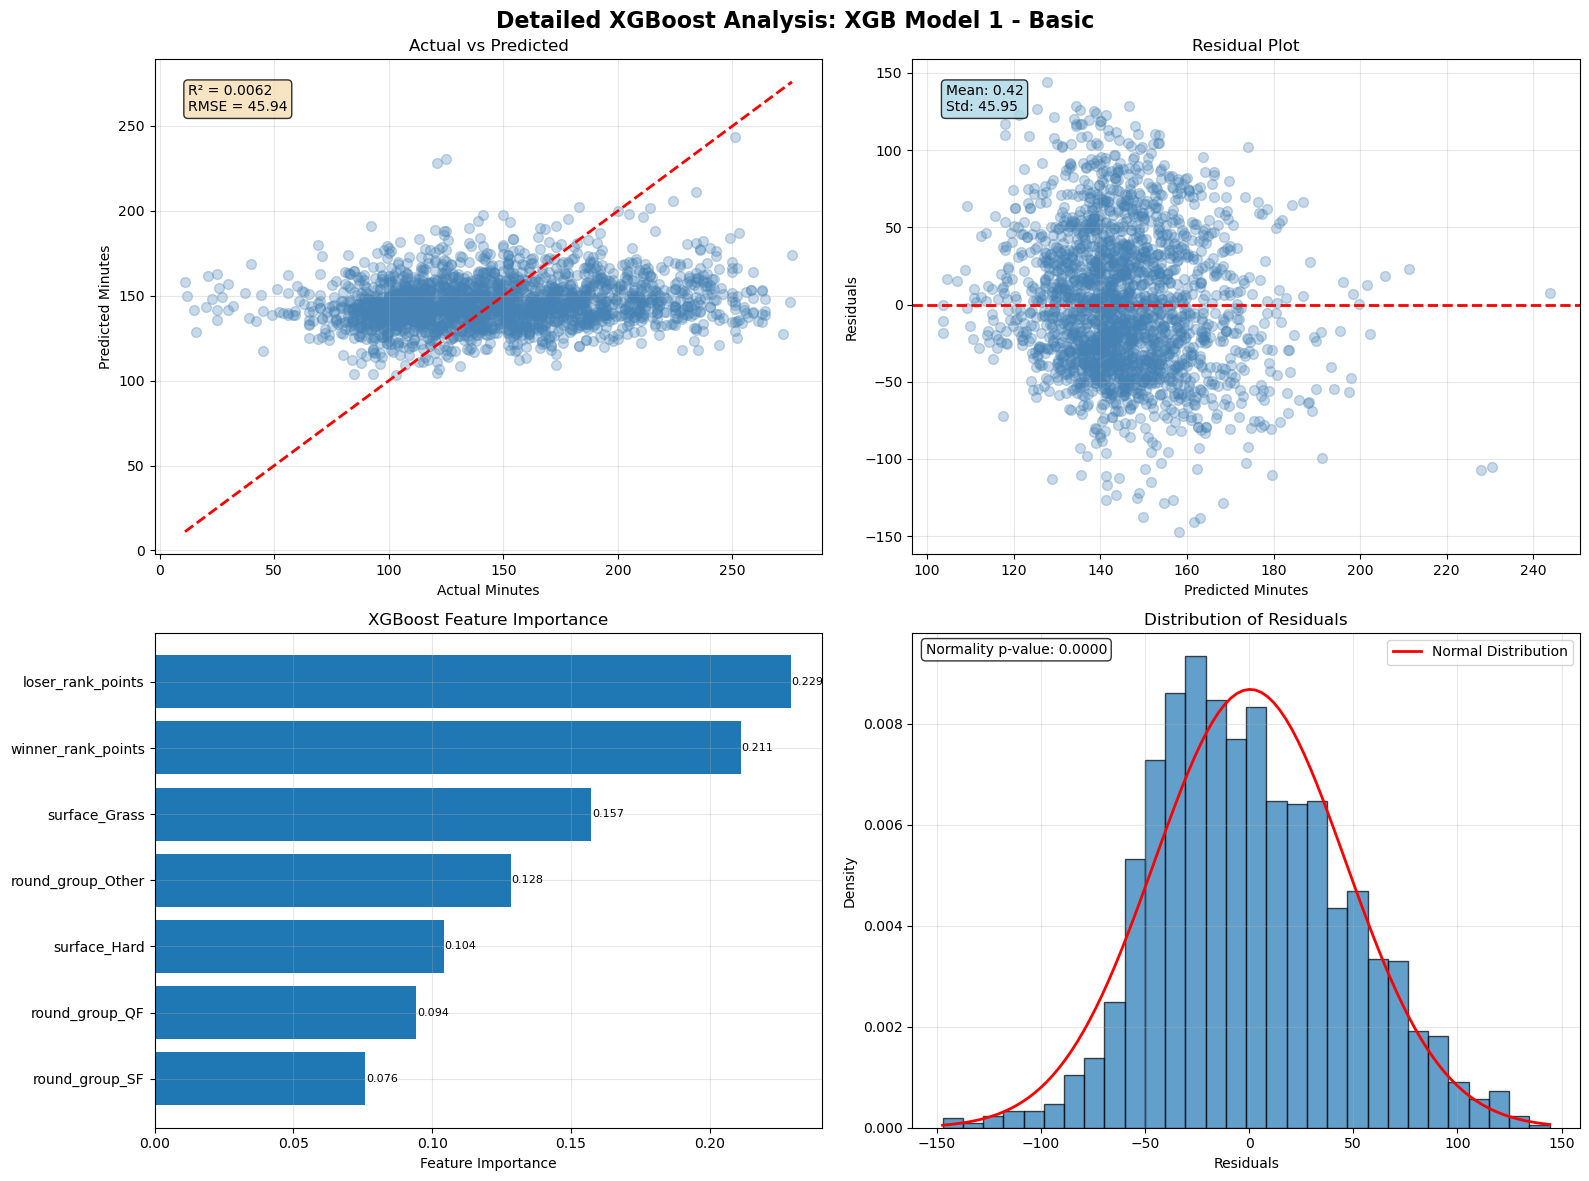

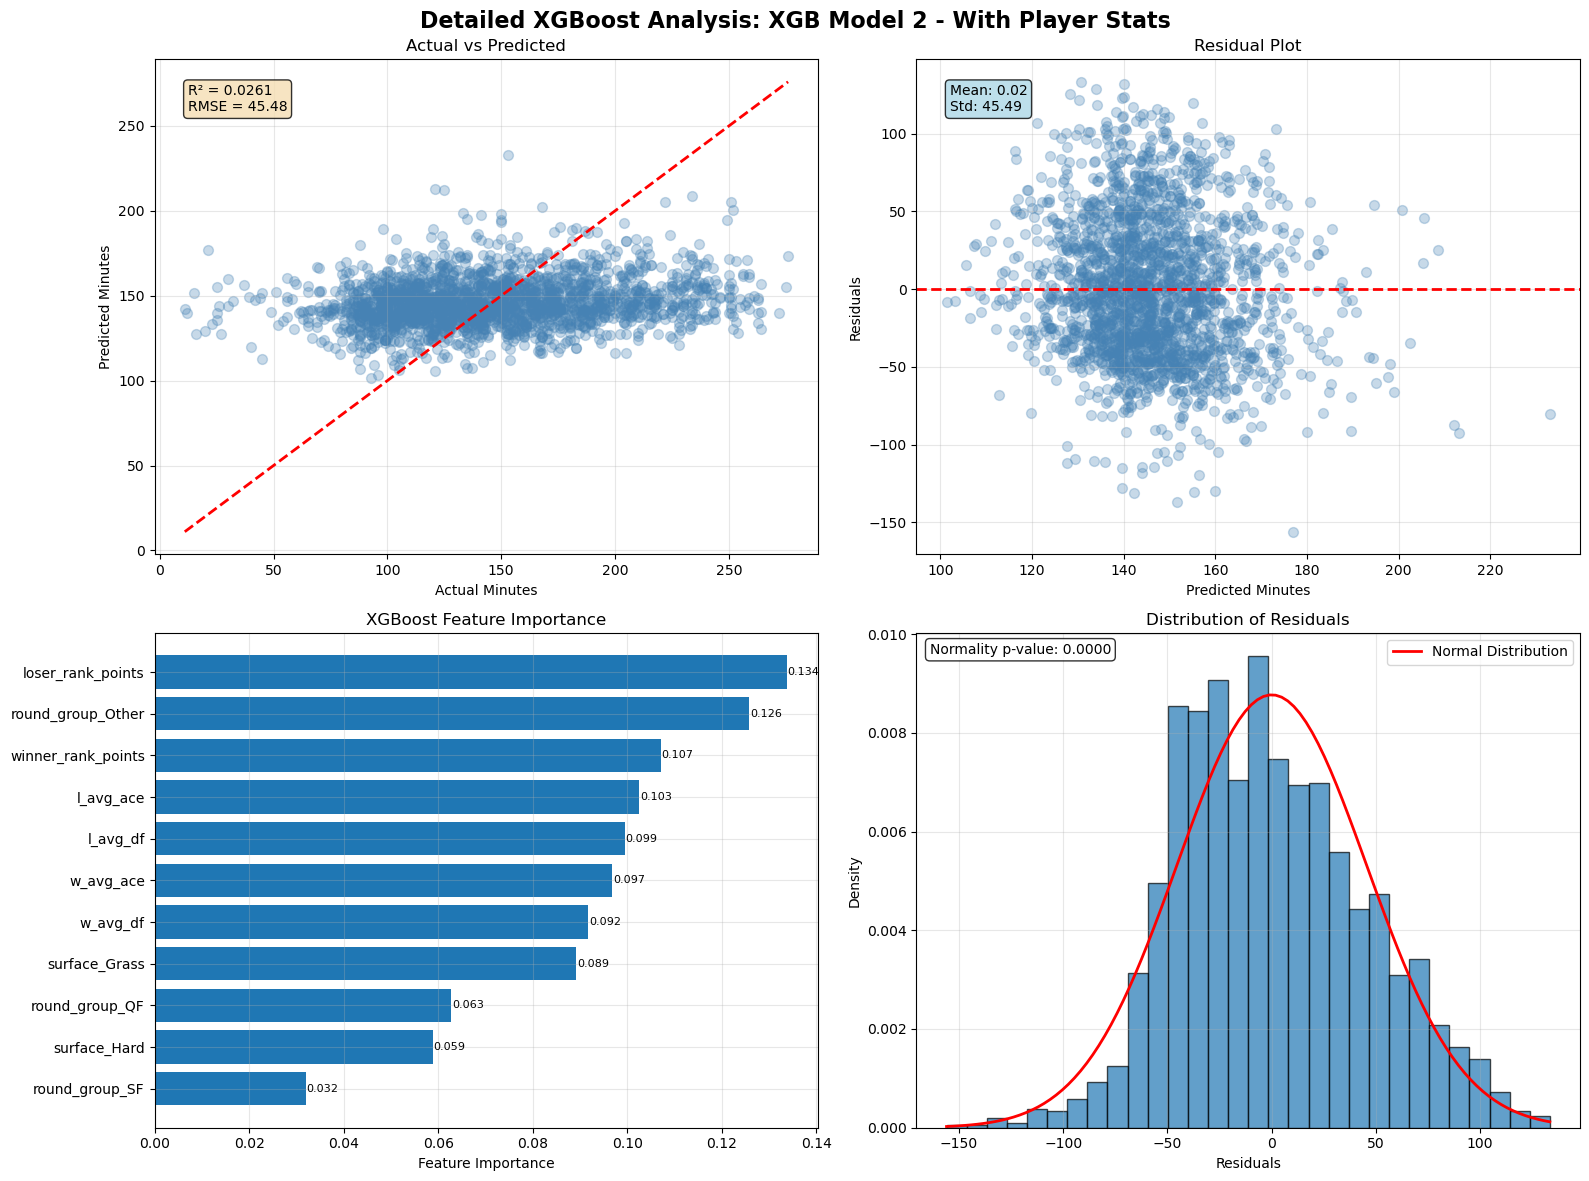

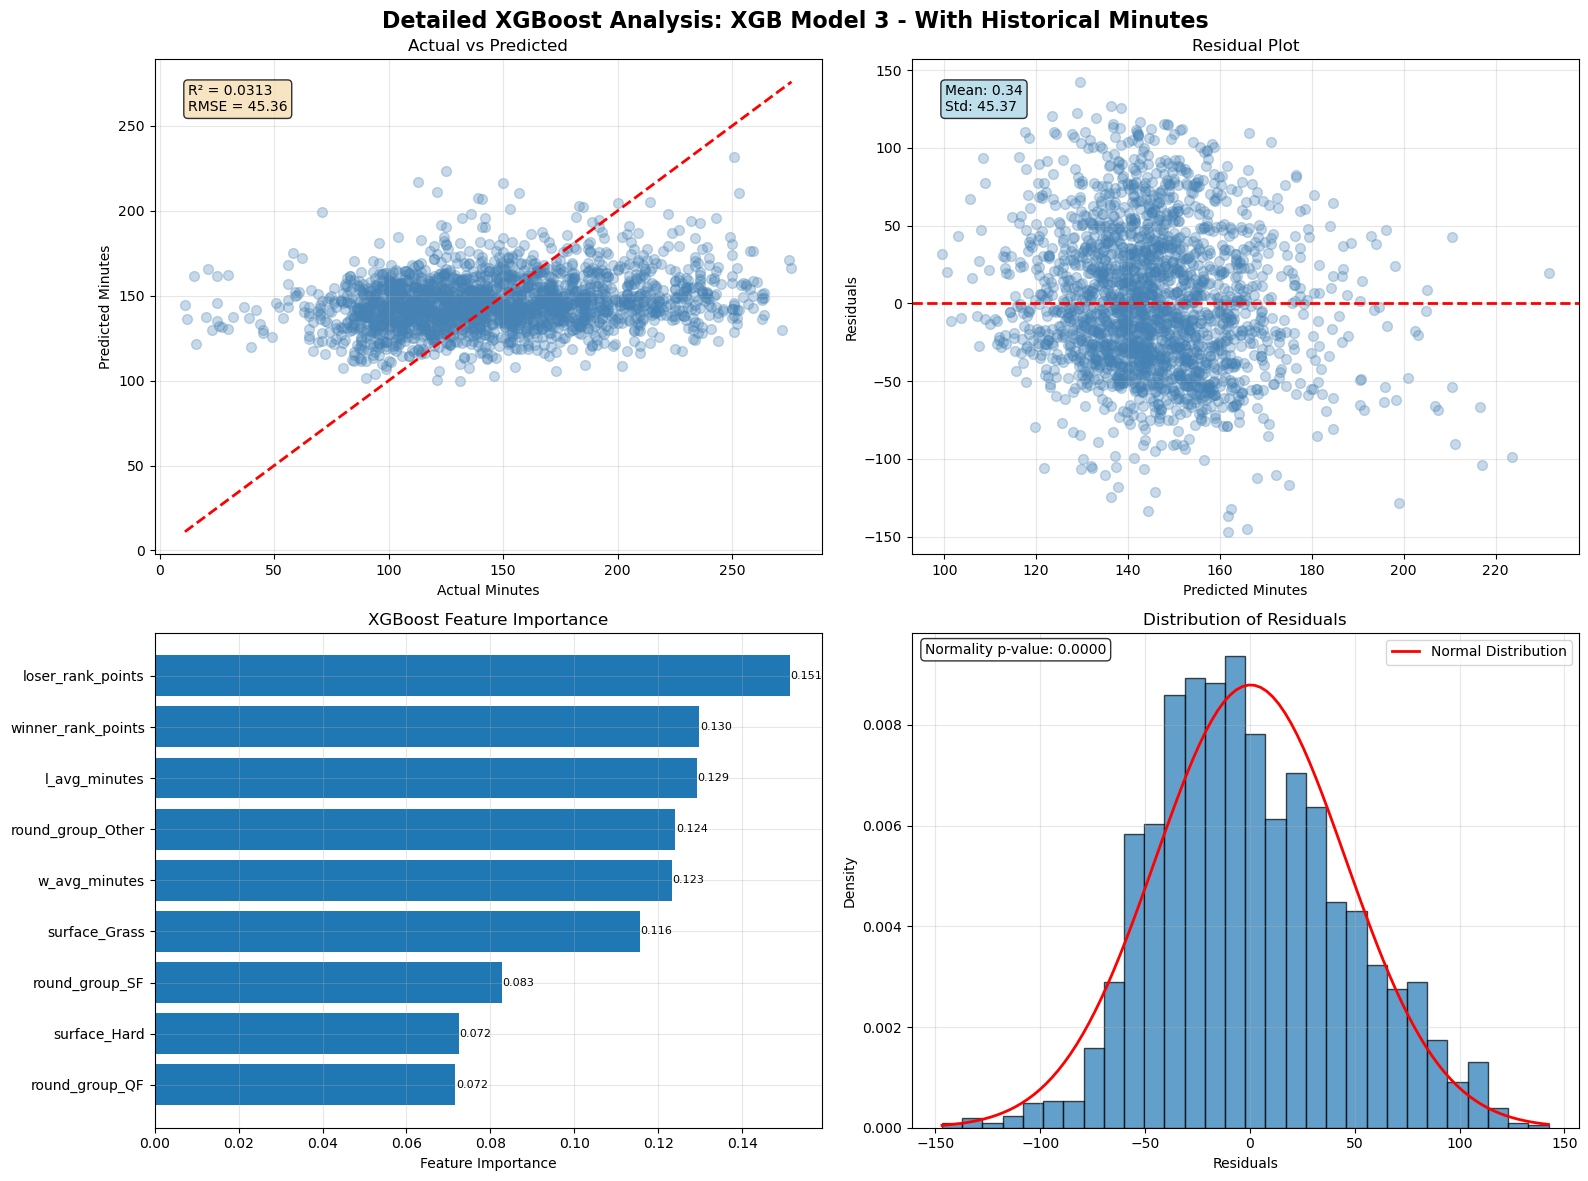

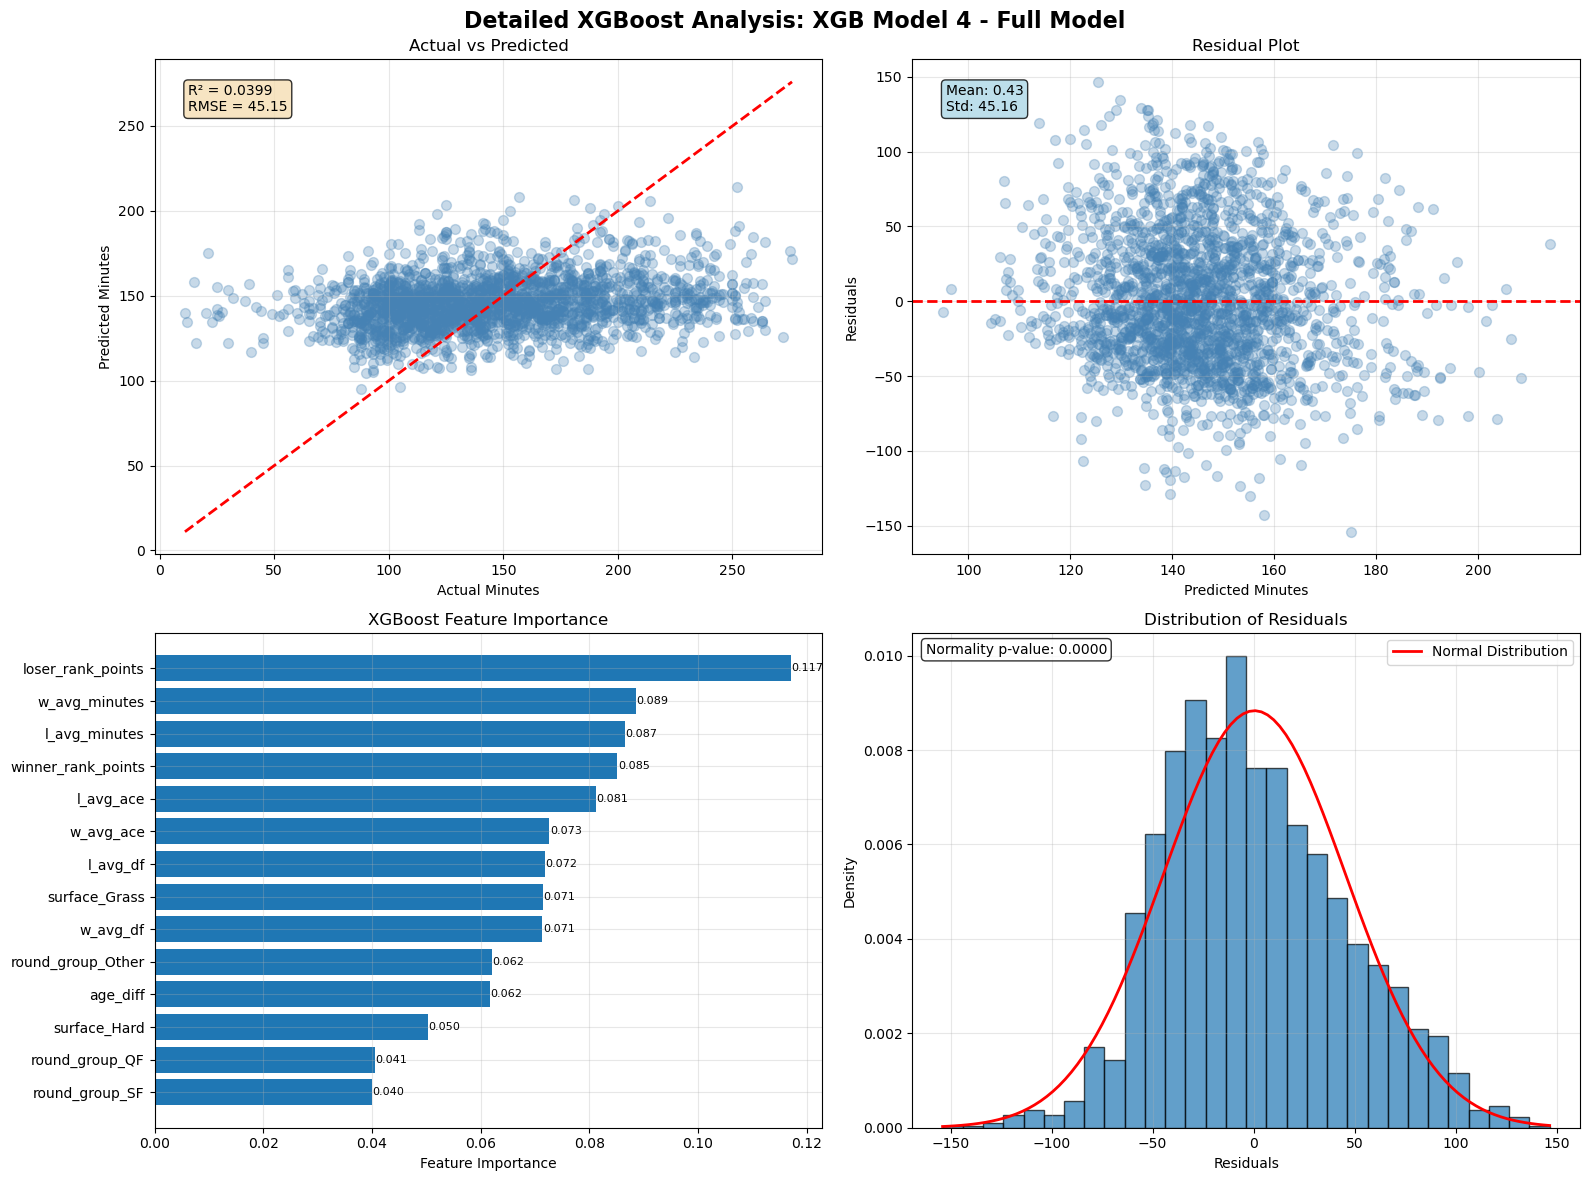

In [61]:
#| echo: false
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
#sns.set_palette("husl")

# Asume que df_clean es tu DataFrame
# df_clean = tu_dataframe_aqui

def create_xgboost_models(df):
    """
    Crea y compara múltiples modelos de regresión XGBoost (sin impresiones).
    """
    
    # Define diferentes conjuntos de características
    models = {
        'XGB Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'XGB Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                           'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'XGB Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                                 'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                                 'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'XGB Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                     'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                     'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    # Variable objetivo
    y = df['minutes']
    
    # Almacenar resultados
    results = {}
    trained_models = {}
    test_data = {}  # Almacenar datos de prueba para cada modelo
    
    for model_name, features in models.items():
        # Preparar datos para este modelo específico
        X = df[features]
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Almacenar datos de prueba para uso posterior
        test_data[model_name] = {'X_test': X_test, 'y_test': y_test_model}
        
        # Crear y entrenar modelo XGBoost
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1,
            objective='reg:squarederror' # explicit objective to suppress warnings
        )
        
        model.fit(X_train, y_train_model)
        
        # Predicciones
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Métricas
        train_r2 = r2_score(y_train_model, y_pred_train)
        test_r2 = r2_score(y_test_model, y_pred_test)
        train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
        train_mae = mean_absolute_error(y_train_model, y_pred_train)
        test_mae = mean_absolute_error(y_test_model, y_pred_test)
        
        # Obtener importancia de características
        feature_importance = model.feature_importances_
        
        # Almacenar resultados
        results[model_name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'features': features,
            'feature_importance': feature_importance
        }
        
        trained_models[model_name] = model
        
    return results, trained_models, test_data

def plot_xgboost_model_comparison(results):
    """
    Crea gráficos de comparación para todos los modelos XGBoost.
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('XGBoost Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models = list(results.keys())
    
    # Comparación R²
    train_r2 = [results[model]['train_r2'] for model in models]
    test_r2 = [results[model]['test_r2'] for model in models]
    
    x = np.arange(len(models))
    width = 0.35
    
    axes[0,0].bar(x - width/2, train_r2, width, label='Train R²', alpha=0.8, color='C0')
    axes[0,0].bar(x + width/2, test_r2, width, label='Test R²', alpha=0.8, color='C1')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison')
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45, ha="right")
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Comparación RMSE
    train_rmse = [results[model]['train_rmse'] for model in models]
    test_rmse = [results[model]['test_rmse'] for model in models]
    
    axes[0,1].bar(x - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='C0')
    axes[0,1].bar(x + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='C1')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45, ha="right")
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Comparación MAE
    train_mae = [results[model]['train_mae'] for model in models]
    test_mae = [results[model]['test_mae'] for model in models]
    
    axes[1,0].bar(x - width/2, train_mae, width, label='Train MAE', alpha=0.8, color='C0')
    axes[1,0].bar(x + width/2, test_mae, width, label='Test MAE', alpha=0.8, color='C1')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45, ha="right")
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Análisis de sobreajuste (Train R² - Test R²)
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models]
    
    axes[1,1].bar(range(len(models)), overfitting, alpha=0.8, color='C0') # Removed color list for simplicity
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticks(range(len(models)))
    axes[1,1].set_xticklabels([m.replace('XGB Model ', 'XGB M') for m in models], rotation=45, ha="right")
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='Overfitting threshold (0.05)')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()

def plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df):
    """
    Análisis detallado de un modelo XGBoost específico (solo gráficos).
    """
    
    model = trained_models[model_name]
    features = results[model_name]['features']
    
    X_test = test_data[model_name]['X_test']
    y_test = test_data[model_name]['y_test']
    
    y_pred = model.predict(X_test)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Detailed XGBoost Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    axes[0,0].scatter(y_test, y_pred, alpha=0.3, color='steelblue', s=50)
    axes[0,0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    axes[0,0].text(0.05, 0.95, f'R² = {r2:.4f}\nRMSE = {rmse:.2f}', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    residuals = y_test - y_pred
    axes[0,1].scatter(y_pred, residuals, alpha=0.3, color='steelblue', s=50)
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Predicted Minutes')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title('Residual Plot')
    axes[0,1].grid(True, alpha=0.3)
    
    res_mean, res_std = residuals.mean(), residuals.std()
    axes[0,1].text(0.05, 0.95, f'Mean: {res_mean:.2f}\nStd: {res_std:.2f}', 
                   transform=axes[0,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': results[model_name]['feature_importance']
    }).sort_values('Importance', ascending=True)
    
    bars = axes[1,0].barh(importance_df['Feature'], importance_df['Importance'], color='C0')
    axes[1,0].set_xlabel('Feature Importance')
    axes[1,0].set_title('XGBoost Feature Importance')
    axes[1,0].grid(True, alpha=0.3)
    
    for i, (bar, importance) in enumerate(zip(bars, importance_df['Importance'])):
        axes[1,0].text(importance + importance_df['Importance'].max() * 0.001, 
                      bar.get_y() + bar.get_height()/2, 
                      f'{importance:.3f}', 
                      va='center', fontsize=8)
    
    axes[1,1].hist(residuals, bins=30, alpha=0.7, edgecolor='black', color='C0', density=True)
    axes[1,1].set_xlabel('Residuals')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Distribution of Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    mu, sigma = residuals.mean(), residuals.std()
    x_norm = np.linspace(residuals.min(), residuals.max(), 100) # Renamed x to x_norm
    normal_dist = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_norm - mu) / sigma) ** 2)
    axes[1,1].plot(x_norm, normal_dist, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    try:
        from scipy import stats
        # Only perform normaltest if residuals are not all zero or constant
        if len(np.unique(residuals)) > 1:
            _, p_value = stats.normaltest(residuals)
            axes[1,1].text(0.02, 0.98, f'Normality p-value: {p_value:.4f}', 
                           transform=axes[1,1].transAxes, verticalalignment='top',
                           bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
        else:
            axes[1,1].text(0.02, 0.98, 'Normality test skipped (constant residuals)',
                           transform=axes[1,1].transAxes, verticalalignment='top',
                           bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    except ImportError:
        axes[1,1].text(0.02, 0.98, 'SciPy not found for normality test',
                       transform=axes[1,1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))


    plt.tight_layout()
    plt.show()

def plot_all_xgboost_models_analysis(results, trained_models, test_data, df):
    """
    Muestra análisis detallado (gráficos) para todos los modelos XGBoost.
    """
    for model_name in results.keys():
        plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df)

def determine_best_xgboost_model_name(results): # Renamed from print_best_xgboost_model_summary
    """
    Determina el mejor modelo XGBoost basado en R² de prueba (sin imprimir).
    """
    if not results:
        return None
    best_model_item = max(results.items(), key=lambda x: x[1]['test_r2'])
    best_name = best_model_item[0]
    return best_name

def run_complete_xgboost_analysis(df):
    """
    Ejecuta el análisis de regresión XGBoost completo y muestra los gráficos.
    """
    results, trained_models, test_data = create_xgboost_models(df)
    plot_xgboost_model_comparison(results)
    _ = determine_best_xgboost_model_name(results) # El nombre se determina pero no se imprime
    plot_all_xgboost_models_analysis(results, trained_models, test_data, df)
    return results, trained_models, test_data # Devuelve test_data también

def run_xgboost_analysis_single_model(df, model_name=None):
    """
    Ejecuta análisis XGBoost para un modelo específico (gráficos) o devuelve objetos.
    Devuelve results, trained_models, y test_data.
    """
    results, trained_models, test_data = create_xgboost_models(df)
    
    if model_name is None:
        # No se realizan gráficos automáticamente.
        pass
    elif model_name in results:
        plot_detailed_xgboost_analysis(model_name, results, trained_models, test_data, df)
    else:
        # Nombre de modelo no encontrado, no hace nada silenciosamente.
        pass
        
    return results, trained_models, test_data

def compare_linear_vs_xgboost_silent(df, linear_results, xgb_results):
    """
    Compara Regresión Lineal vs XGBoost (sin impresiones).
    Esta función ahora no producirá salida visible. Podría modificarse para devolver
    un DataFrame o diccionario con los datos de comparación si se necesita.
    """
    # La lógica de comparación está aquí, pero no se imprime nada.
    # Se podrían almacenar los datos de comparación en una estructura si fuera necesario.
    _comparison_data_collected = [] # Placeholder si se quisiera recolectar datos
    model_mapping = {
        'Model 1 - Basic': 'XGB Model 1 - Basic',
        'Model 2 - With Player Stats': 'XGB Model 2 - With Player Stats',
        'Model 3 - With Historical Minutes': 'XGB Model 3 - With Historical Minutes',
        'Model 4 - Full Model': 'XGB Model 4 - Full Model'
    }
    
    for linear_name, xgb_name in model_mapping.items():
        if linear_name in linear_results and xgb_name in xgb_results:
            # Realizar cálculos como antes, pero no imprimirlos.
            # Ejemplo:
            # linear_r2 = linear_results[linear_name]['test_r2']
            # xgb_r2 = xgb_results[xgb_name]['test_r2']
            # ... etc.
            # _comparison_data_collected.append({'linear_name': linear_name, ...})
            pass # No se realizan acciones visibles

# --- INSTRUCCIONES DE USO ---
# Asegúrate de que tu DataFrame 'df_clean' esté cargado y preprocesado.
# La variable 'linear_results' necesitaría ser definida ejecutando tu script de regresión lineal anterior.

# Ejemplo de cómo podrías llamar a las funciones (descomenta según necesites):

# Para ejecutar el análisis completo de XGBoost (solo gráficos):
# (Asegúrate de que 'df_clean' esté definido)
# xgb_results, xgb_models, xgb_test_data = run_complete_xgboost_analysis(df_clean)

# Para ejecutar el análisis de un solo modelo XGBoost (solo gráficos de ese modelo):
# (Asegúrate de que 'df_clean' esté definido)
# xgb_results_single, xgb_models_single, xgb_test_data_single = run_xgboost_analysis_single_model(df_clean, 'XGB Model 4 - Full Model')

# Para comparar (esta función ahora no imprime, necesitarías resultados de análisis lineal):
# Asumiendo que tienes 'linear_results' de un análisis anterior:
# compare_linear_vs_xgboost_silent(df_clean, linear_results, xgb_results)


# La línea que proporcionaste para ejecutar:
# (Asegúrate de que 'df_clean' esté definido con tus datos antes de ejecutar esto)
xgb_results, xgb_models, xgb_test_data = run_complete_xgboost_analysis(df_clean)

## Análisis de Resultados

En este estudio implementamos cuatro configuraciones del modelo XGBoost para predecir la duración de partidos de tenis.  
- XGB Modelo 1: variables estructurales del torneo (7 características).  
- XGB Modelo 2: agrega datos de performance individual (11 características).  
- XGB Modelo 3: incorpora la duración promedio histórica por jugador (9 características).  
- XGB Modelo 4: combina todas las variables disponibles (14 características).  

A medida que añadimos información, se observa una mejora gradual en MAE y R² de prueba, aunque persiste un marcado sobreajuste en entrenamiento versus prueba

In [82]:
#| echo: false
data_metrics = {
    'Modelo': ['1', '2', '3', '4'],
    'R²_train': [0.2035, 0.3361, 0.3363, 0.3977],
    'R²_test': [0.0121, 0.0197, 0.0276, 0.0289],
    'RMSE_train': [41.34, 37.74, 37.74, 35.95],
    'RMSE_test': [45.80, 45.63, 45.44, 45.41],
    'MAE_train': [33.28, 30.14, 30.22, 28.66],
    'MAE_test': [37.05, 36.86, 36.73, 36.71],
    'N° Variables': [7, 11, 9, 14]
}

df_metrics = pd.DataFrame(data_metrics)

data_features_interpretation = {
    'Modelo': ['1', '2', '3', '4'],
    '3 Características Principales': [
        "1. loser_rank_points (0.2539)\n2. winner_rank_points (0.2147)\n3. surface_Grass (0.1307)",
        "1. loser_rank_points (0.1393)\n2. round_group_Other (0.1175)\n3. winner_rank_points (0.1087)",
        "1. loser_rank_points (0.1568)\n2. winner_rank_points (0.1287)\n3. round_group_Other (0.1275)",
        "1. loser_rank_points (0.1203)\n2. w_avg_minutes (0.0889)\n3. winner_rank_points (0.0879)"
    ],
    'Interpretación Breve': [
        "- Partidos con perdedor de mayor ranking tienden a durar más, indicando paridad.\n- Puntaje del ganador también extiende la duración por nivel competitivo.\n- Césped acorta los partidos por intercambios rápidos.",
        "- Reafirma la competitividad del perdedor.\n- Rondas iniciales (“Other”) son más cortas por menor presión.\n- Puntaje del ganador mantiene relevancia.",
        "- Competitividad del perdedor sigue siendo clave.\n- Puntaje del ganador continúa influyendo.\n- Rondas iniciales muestran menor duración promedio.",
        "- Continúa como predictor más influyente.\n- Duración histórica promedio aporta valor explicativo.\n- Puntaje del ganador conserva importancia."
    ]
}


#### Resultados de Desempeño Predictivo

In [ ]:
#| echo: false
df_metrics.set_index('Modelo')

R²_train  R²_test  RMSE_train  RMSE_test  MAE_train  MAE_test  \
Modelo                                                                  
1         0.2035   0.0121       41.34      45.80      33.28     37.05   
2         0.3361   0.0197       37.74      45.63      30.14     36.86   
3         0.3363   0.0276       37.74      45.44      30.22     36.73   
4         0.3977   0.0289       35.95      45.41      28.66     36.71   

        N° Variables  
Modelo                
1                  7  
2                 11  
3                  9  
4                 14

#### Importancia de Características e Interpretación

#### Interpretación

Aunque el MAE de prueba mejora ligeramente (de 37.05 min en el Modelo 1 a 36.71 min en el Modelo 4), la capacidad predictiva en prueba sigue siendo reducida, con $R^2$ muy bajos (0.0121–0.0289). Se detecta un sobreajuste significativo: la brecha entre entrenamiento y prueba alcanza hasta 0.3688 en el Modelo 4, lo que indica que el ensamble captura patrones específicos del set de entrenamiento sin generalizar adecuadamente.  

En todos los modelos, los puntos de ranking del perdedor son el factor más relevante, sugiriendo que la competitividad del oponente influye de forma consistente en la duración de los partidos. La inclusión de la duración histórica promedio (w_avg_minutes) aporta un valor moderado en el modelo completo, pero sigue sin resolver el bajo poder predictivo global. Estos resultados invitan a explorar variables adicionales, como condiciones climáticas o estilos de juego y a probar enfoques híbridos o de ingeniería de características para mejorar la robustez del pronóstico.  


# GLM Gamma

## Marco Teórico

Los Modelos Lineales Generalizados (GLM) extienden la regresión lineal clásica para acomodar variables de respuesta que no siguen una distribución normal. Dentro de este marco, la regresión Gamma resulta especialmente adecuada cuando la variable dependiente es continua, estrictamente positiva y presenta asimetría derecha con varianza creciente conforme aumenta la media.

En un GLM Gamma, se asume que cada observación $Y_i$ sigue una distribución Gamma con función de densidad

$$
f(y_i;\,\mu_i,\phi) \;=\; \frac{1}{\Gamma(1/\phi)}\Bigl(\frac{1}{\phi \mu_i}\Bigr)^{1/\phi} y_i^{1/\phi -1} \exp\!\Bigl(-\frac{y_i}{\phi \mu_i}\Bigr),
$$

donde $\mu_i = E[Y_i]$ es la media y $\phi$ el parámetro de dispersión. La relación media-varianza característica es

$$
\operatorname{Var}(Y_i) = \phi\,\mu_i^2,
$$

lo cual refleja heterocedasticidad proporcional al cuadrado de la media.

Se elige típicamente la función de enlace logarítmica como vínculo canónico, de modo que

$$
g(\mu_i) = \log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \cdots + \beta_p x_{ip}.
$$

Esto garantiza predicciones positivas y permite interpretar cada coeficiente $\beta_j$ como el cambio logarítmico en la media al incrementar en una unidad la covariable $x_{ij}$, es decir, un efecto multiplicativo $\exp(\beta_j)$ sobre $\mu_i$.

La estimación de los parámetros $\boldsymbol{\beta}$ y $\phi$ se realiza mediante máxima verosimilitud, optimizando la log-verosimilitud del modelo. El ajuste se evalúa a través de la desviance y criterios de información como AIC y BIC, además de pseudo-$R^2$ para medir bondad de ajuste relativa.

En comparación con la regresión lineal, el GLM Gamma maneja de forma nativa la distribución sesgada y la heterocedasticidad creciente, mejorando la validez estadística cuando los supuestos de homocedasticidad y normalidad no se cumplen. Por ello, resulta apropiado para modelar tiempos de duración u otras magnitudes positivas donde la variabilidad se incrementa con el nivel promedio observado.  

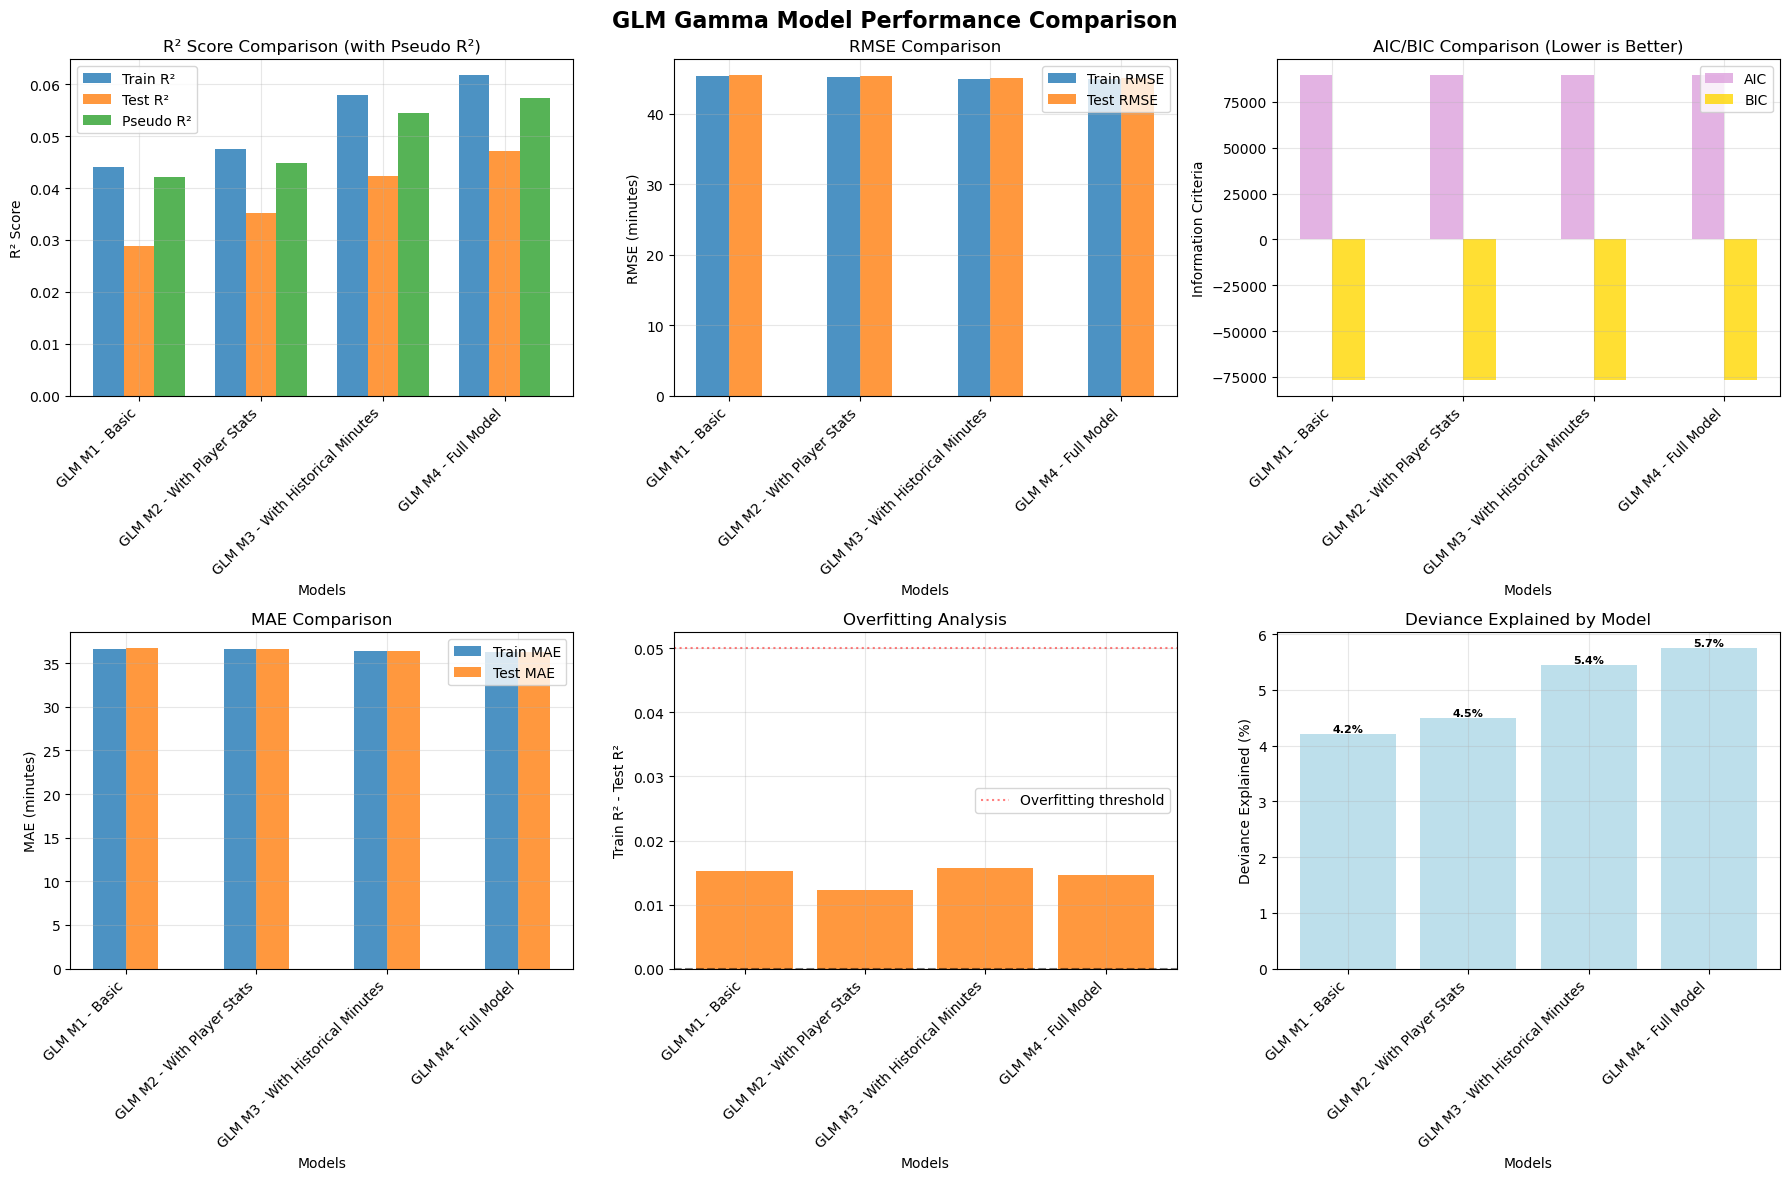

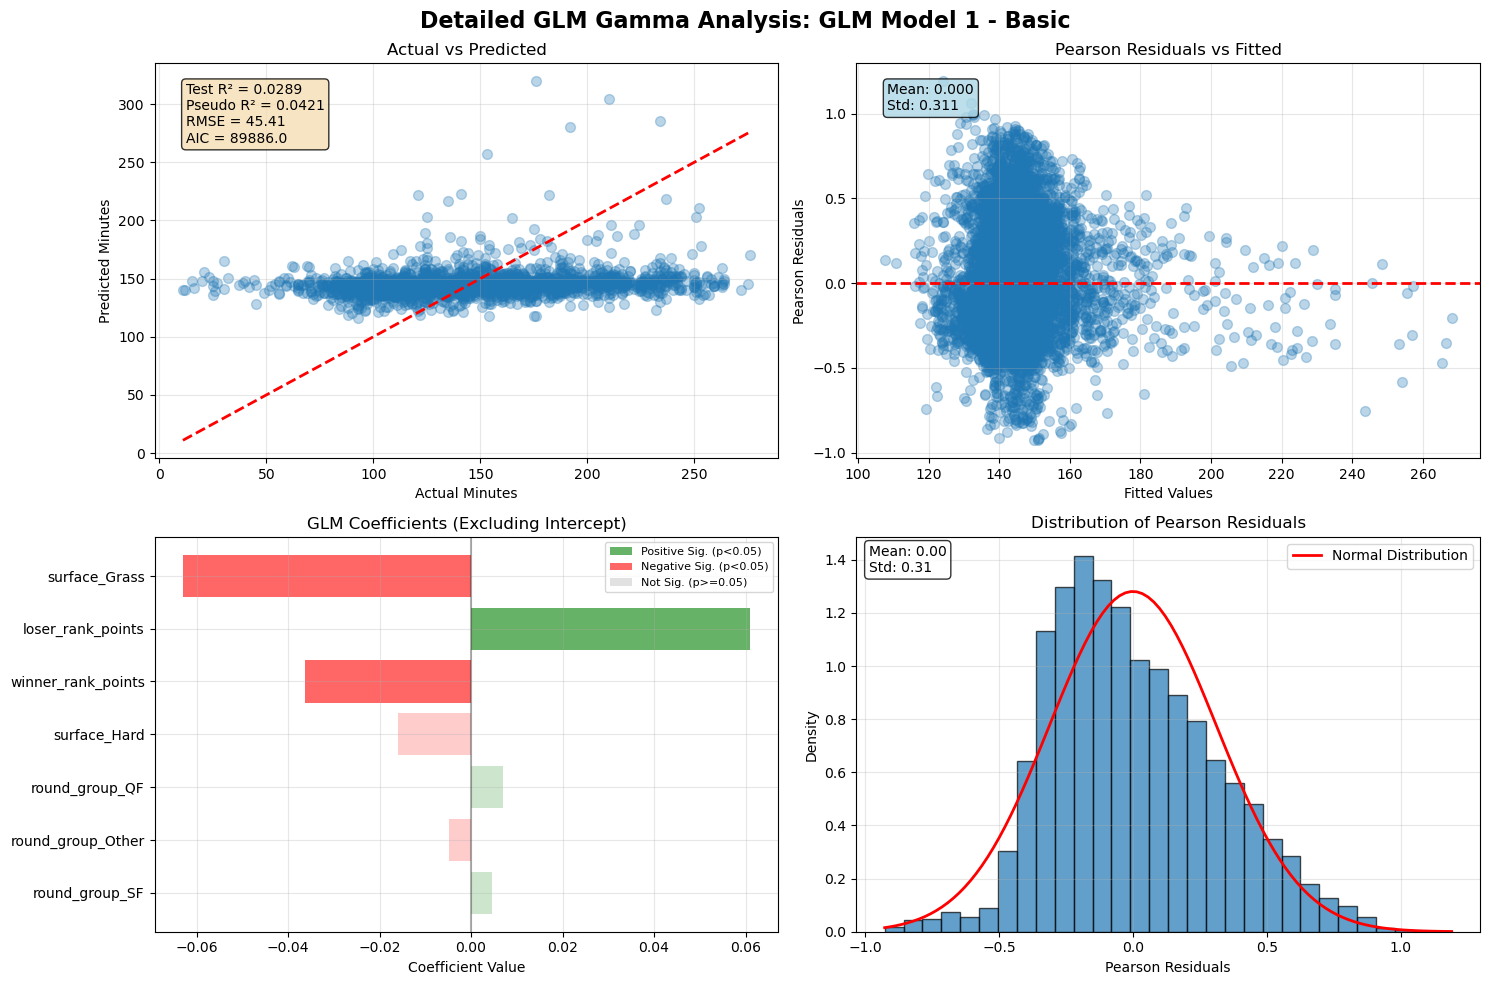

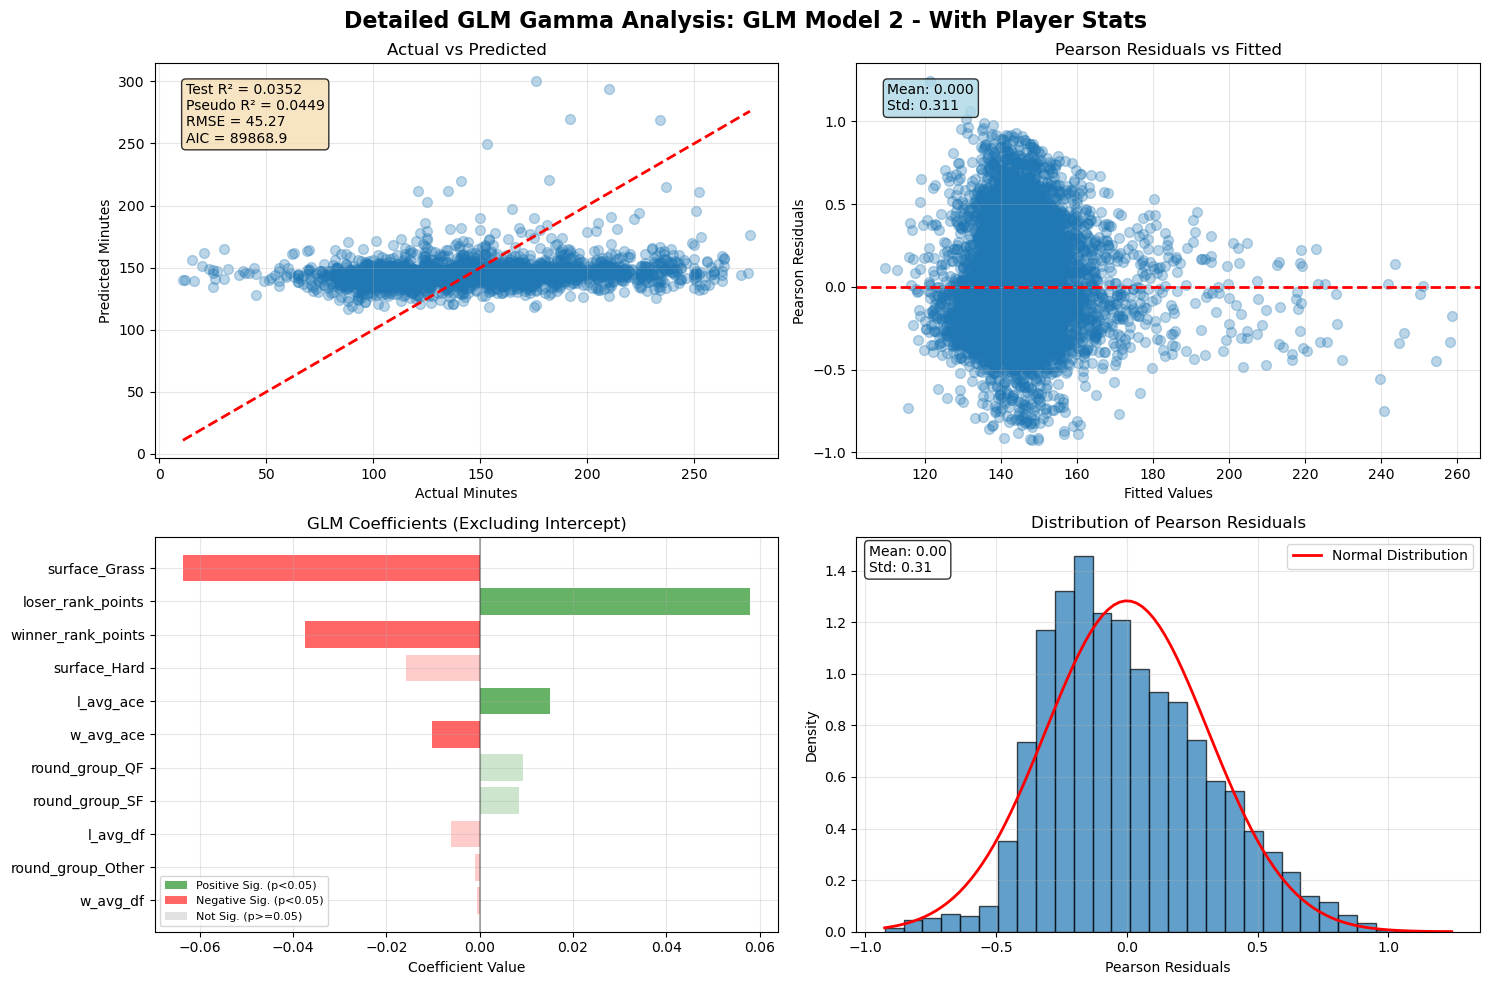

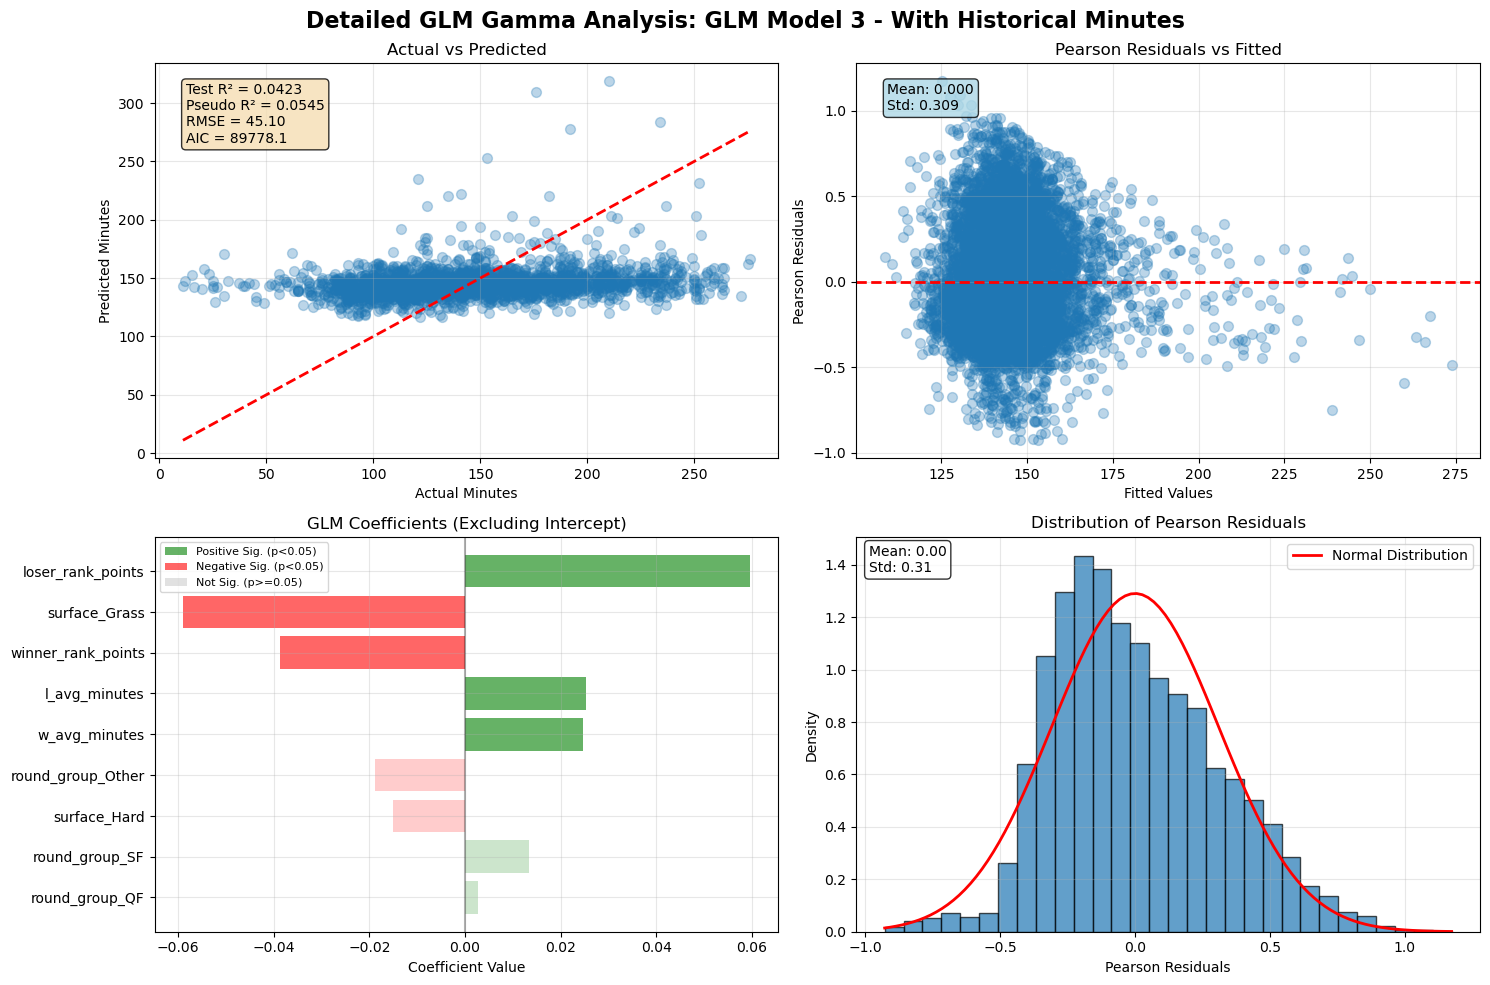

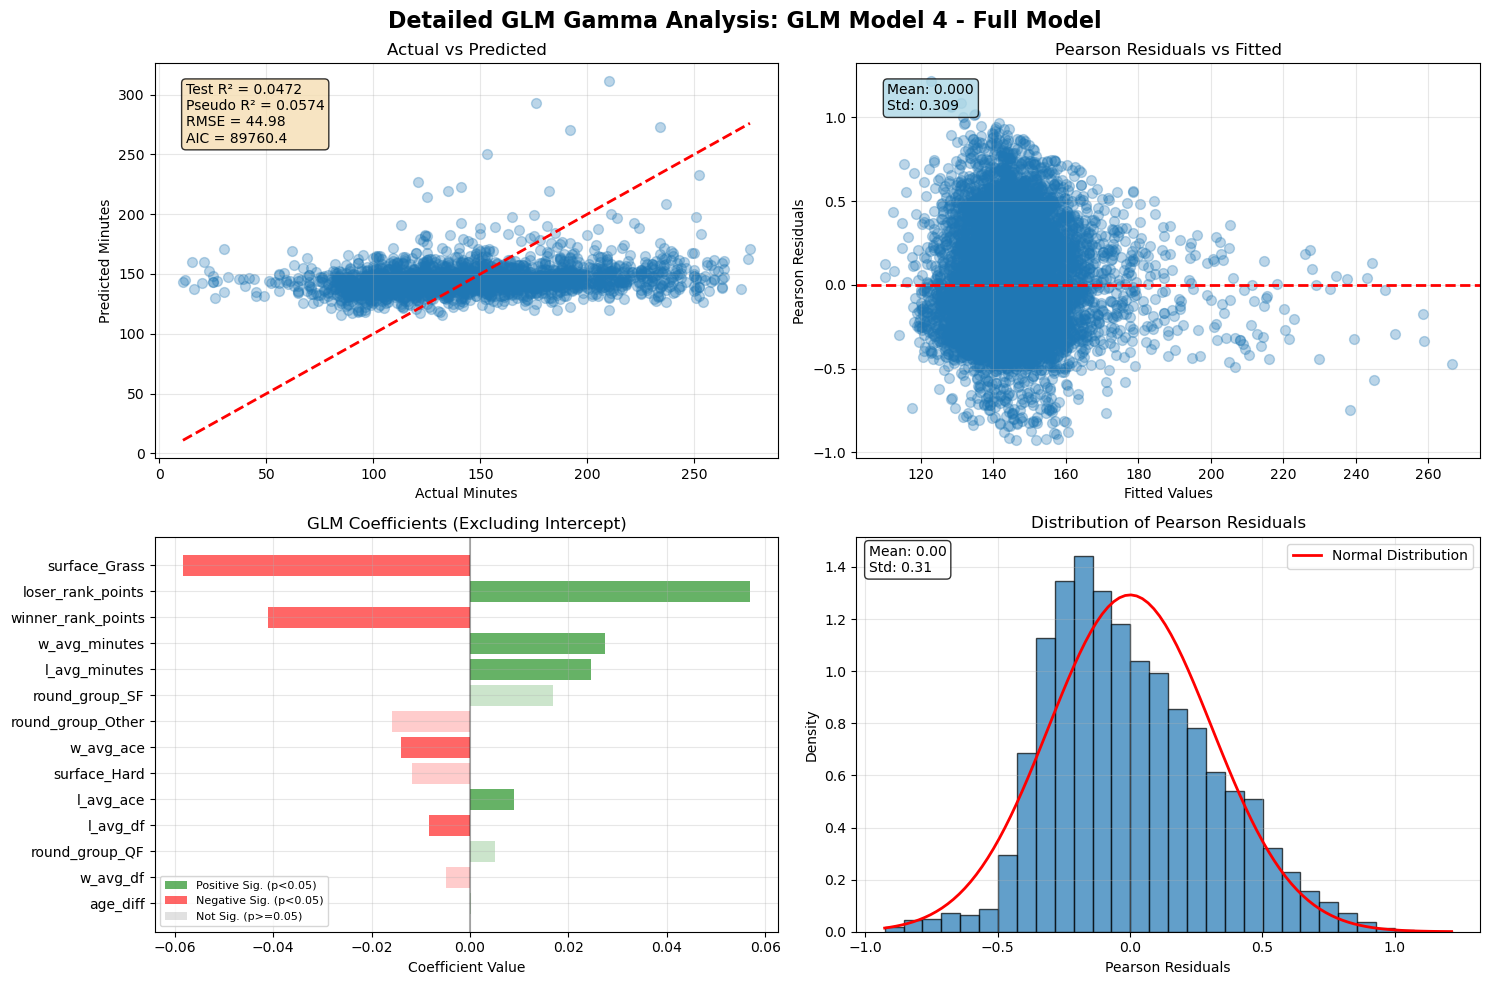

In [ ]:
#| echo: false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.genmod.families import Gamma
from matplotlib.patches import Patch # Ensured import
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('default')
#sns.set_palette("husl")

# Assume df_clean is your DataFrame
# df_clean = your_dataframe_here

def create_glm_gamma_models(df):
    """
    Crea y compara múltiples modelos de regresión GLM Gamma (sin impresiones).
    """
    
    models = {
        'GLM Model 1 - Basic': ['round_group_QF', 'round_group_SF', 'round_group_Other', 
                                'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points'],
        
        'GLM Model 2 - With Player Stats': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                           'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                           'loser_rank_points', 'w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'],
        
        'GLM Model 3 - With Historical Minutes': ['round_group_QF', 'round_group_SF', 'round_group_Other',
                                                 'surface_Grass', 'surface_Hard', 'winner_rank_points', 
                                                 'loser_rank_points', 'w_avg_minutes', 'l_avg_minutes'],
        
        'GLM Model 4 - Full Model': ['age_diff', 'round_group_QF', 'round_group_SF', 'round_group_Other',
                                     'surface_Grass', 'surface_Hard', 'winner_rank_points', 'loser_rank_points',
                                     'w_avg_ace', 'w_avg_df', 'w_avg_minutes', 'l_avg_ace', 'l_avg_df', 'l_avg_minutes']
    }
    
    y = df['minutes']
    results = {}
    trained_models = {}
    test_data = {}
    scalers = {}
    
    for model_name, features in models.items():
        X = df[features].copy()
        X_train, X_test, y_train_model, y_test_model = train_test_split(X, y, test_size=0.2, random_state=42)
        
        scaler = StandardScaler()
        continuous_vars = ['winner_rank_points', 'loser_rank_points']
        if 'w_avg_ace' in features:
            continuous_vars.extend(['w_avg_ace', 'w_avg_df', 'l_avg_ace', 'l_avg_df'])
        if 'w_avg_minutes' in features:
            continuous_vars.extend(['w_avg_minutes', 'l_avg_minutes'])
        if 'age_diff' in features:
            continuous_vars.append('age_diff')
        
        continuous_vars_present = [var for var in continuous_vars if var in X_train.columns]
        
        X_train_scaled = X_train.copy()
        X_test_scaled = X_test.copy()
        if continuous_vars_present:
            X_train_scaled[continuous_vars_present] = scaler.fit_transform(X_train[continuous_vars_present])
            X_test_scaled[continuous_vars_present] = scaler.transform(X_test[continuous_vars_present])
        
        X_train_with_intercept = sm.add_constant(X_train_scaled, has_constant='add')
        X_test_with_intercept = sm.add_constant(X_test_scaled, has_constant='add')
        
        current_feature_names = ['const'] + list(X_train_scaled.columns)

        test_data[model_name] = {
            'X_test': X_test_with_intercept, 
            'y_test': y_test_model,
            'X_test_original': X_test,
            'feature_names': current_feature_names
        }
        scalers[model_name] = scaler
        
        try:
            model_glm = sm.GLM(y_train_model, X_train_with_intercept, 
                               family=Gamma(link=sm.families.links.log()))
            fitted_model = model_glm.fit()
            
            try:
                y_pred_train = fitted_model.predict(X_train_with_intercept)
                y_pred_test = fitted_model.predict(X_test_with_intercept)
                y_pred_train = np.maximum(y_pred_train, 1e-9) # Use a very small positive number
                y_pred_test = np.maximum(y_pred_test, 1e-9)
            except Exception: 
                y_pred_train = np.full(len(y_train_model), y_train_model.mean())
                y_pred_test = np.full(len(y_test_model), y_train_model.mean())
            
            train_r2 = r2_score(y_train_model, y_pred_train)
            test_r2 = r2_score(y_test_model, y_pred_test)
            train_rmse = np.sqrt(mean_squared_error(y_train_model, y_pred_train))
            test_rmse = np.sqrt(mean_squared_error(y_test_model, y_pred_test))
            train_mae = mean_absolute_error(y_train_model, y_pred_train)
            test_mae = mean_absolute_error(y_test_model, y_pred_test)
            
            aic = fitted_model.aic
            bic = fitted_model.bic
            deviance = fitted_model.deviance
            null_deviance = fitted_model.null_deviance
            pseudo_r2 = 1 - (deviance / null_deviance) if null_deviance > 0 else 0
            
            coefficients = fitted_model.params
            p_values = fitted_model.pvalues
            
            results[model_name] = {
                'train_r2': train_r2, 'test_r2': test_r2, 'pseudo_r2': pseudo_r2,
                'train_rmse': train_rmse, 'test_rmse': test_rmse,
                'train_mae': train_mae, 'test_mae': test_mae,
                'aic': aic, 'bic': bic, 'deviance': deviance, 'null_deviance': null_deviance,
                'features': list(X_train_scaled.columns), 
                'coefficients': coefficients, 'p_values': p_values,
                'feature_names': current_feature_names, 
                'fitted_model': fitted_model
            }
            trained_models[model_name] = fitted_model
            
        except Exception: 
            results[model_name] = {
                'train_r2': 0, 'test_r2': 0, 'pseudo_r2': 0,
                'train_rmse': float('inf'), 'test_rmse': float('inf'),
                'train_mae': float('inf'), 'test_mae': float('inf'),
                'aic': float('inf'), 'bic': float('inf'),
                'deviance': float('inf'), 'null_deviance': float('inf'), # Use inf for deviance too
                'features': features, 'coefficients': None, 'p_values': None,
                'feature_names': ['const'] + list(features),
                'fitted_model': None
            }
            trained_models[model_name] = None
    
    return results, trained_models, test_data, scalers

def plot_glm_gamma_model_comparison(results):
    """
    Crea gráficos de comparación para todos los modelos GLM Gamma.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('GLM Gamma Model Performance Comparison', fontsize=16, fontweight='bold')
    
    models_keys = list(results.keys()) 
    
    train_r2 = [results[model]['train_r2'] for model in models_keys]
    test_r2 = [results[model]['test_r2'] for model in models_keys]
    pseudo_r2 = [results[model]['pseudo_r2'] for model in models_keys]
    
    x_indices = np.arange(len(models_keys)) 
    width = 0.25
    
    axes[0,0].bar(x_indices - width, train_r2, width, label='Train R²', alpha=0.8, color='C0')
    axes[0,0].bar(x_indices, test_r2, width, label='Test R²', alpha=0.8, color='C1')
    axes[0,0].bar(x_indices + width, pseudo_r2, width, label='Pseudo R²', alpha=0.8, color='C2')
    axes[0,0].set_xlabel('Models')
    axes[0,0].set_ylabel('R² Score')
    axes[0,0].set_title('R² Score Comparison (with Pseudo R²)')
    axes[0,0].set_xticks(x_indices)
    axes[0,0].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models_keys], rotation=45, ha="right")
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    train_rmse = [results[model]['train_rmse'] for model in models_keys]
    test_rmse = [results[model]['test_rmse'] for model in models_keys]
    
    axes[0,1].bar(x_indices - width/2, train_rmse, width, label='Train RMSE', alpha=0.8, color='C0')
    axes[0,1].bar(x_indices + width/2, test_rmse, width, label='Test RMSE', alpha=0.8, color='C1')
    axes[0,1].set_xlabel('Models')
    axes[0,1].set_ylabel('RMSE (minutes)')
    axes[0,1].set_title('RMSE Comparison')
    axes[0,1].set_xticks(x_indices)
    axes[0,1].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models_keys], rotation=45, ha="right")
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    valid_models_aic_bic = [m for m in models_keys if results[m]['aic'] != float('inf') and results[m]['bic'] != float('inf')]
    if valid_models_aic_bic:
        aic_values = [results[model]['aic'] for model in valid_models_aic_bic]
        bic_values = [results[model]['bic'] for model in valid_models_aic_bic]
        x_valid_aic_bic = np.arange(len(valid_models_aic_bic))
        
        axes[0,2].bar(x_valid_aic_bic - width/2, aic_values, width, label='AIC', alpha=0.8, color='plum')
        axes[0,2].bar(x_valid_aic_bic + width/2, bic_values, width, label='BIC', alpha=0.8, color='gold')
        axes[0,2].set_xlabel('Models')
        axes[0,2].set_ylabel('Information Criteria')
        axes[0,2].set_title('AIC/BIC Comparison (Lower is Better)')
        axes[0,2].set_xticks(x_valid_aic_bic)
        axes[0,2].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in valid_models_aic_bic], rotation=45, ha="right")
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)
    else:
        axes[0,2].text(0.5, 0.5, "AIC/BIC data not available\nfor any model.", horizontalalignment='center', verticalalignment='center', transform=axes[0,2].transAxes)
        axes[0,2].set_title('AIC/BIC Comparison (Lower is Better)')

    train_mae = [results[model]['train_mae'] for model in models_keys]
    test_mae = [results[model]['test_mae'] for model in models_keys]
    
    axes[1,0].bar(x_indices - width/2, train_mae, width, label='Train MAE', alpha=0.8, color='C0')
    axes[1,0].bar(x_indices + width/2, test_mae, width, label='Test MAE', alpha=0.8, color='C1')
    axes[1,0].set_xlabel('Models')
    axes[1,0].set_ylabel('MAE (minutes)')
    axes[1,0].set_title('MAE Comparison')
    axes[1,0].set_xticks(x_indices)
    axes[1,0].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models_keys], rotation=45, ha="right")
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    overfitting = [results[model]['train_r2'] - results[model]['test_r2'] for model in models_keys]
    
    axes[1,1].bar(range(len(models_keys)), overfitting, alpha=0.8, color='C1')
    axes[1,1].set_xlabel('Models')
    axes[1,1].set_ylabel('Train R² - Test R²')
    axes[1,1].set_title('Overfitting Analysis')
    axes[1,1].set_xticks(range(len(models_keys)))
    axes[1,1].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models_keys], rotation=45, ha="right")
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1,1].axhline(y=0.05, color='red', linestyle=':', alpha=0.5, label='Overfitting threshold')
    axes[1,1].legend()
    
    deviance_explained = []
    for model_key in models_keys: 
        if results[model_key]['null_deviance'] != float('inf') and results[model_key]['null_deviance'] > 0 and results[model_key]['deviance'] != float('inf'):
            dev_exp = (1 - results[model_key]['deviance'] / results[model_key]['null_deviance']) * 100
            deviance_explained.append(dev_exp)
        else:
            deviance_explained.append(0) 
    
    bars = axes[1,2].bar(models_keys, deviance_explained, alpha=0.8, color='lightblue')
    axes[1,2].set_xlabel('Models')
    axes[1,2].set_ylabel('Deviance Explained (%)')
    axes[1,2].set_title('Deviance Explained by Model')
    axes[1,2].set_xticklabels([m.replace('GLM Model ', 'GLM M') for m in models_keys], rotation=45, ha="right")
    axes[1,2].grid(True, alpha=0.3)
    
    for bar, pct in zip(bars, deviance_explained):
        if pct > 0.001 or pct < -0.001 : 
            axes[1,2].text(bar.get_x() + bar.get_width()/2, bar.get_height(), # Adjusted y for better placement
                          f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=8)
    
    plt.tight_layout()
    plt.show()

def plot_detailed_glm_gamma_analysis(model_name, results, trained_models, test_data, df):
    """
    Análisis detallado de un modelo GLM Gamma específico (solo gráficos).
    """
    fitted_model_obj = trained_models.get(model_name) 
    model_results_data = results.get(model_name) 
    
    if fitted_model_obj is None or model_results_data is None or model_results_data.get('fitted_model') is None:
        return
    
    X_test_data = test_data[model_name]['X_test'] 
    y_test_data = test_data[model_name]['y_test'] 
    
    try:
        y_pred_data = fitted_model_obj.predict(X_test_data) 
        y_pred_data = np.maximum(y_pred_data, 1e-9)
    except:
        y_pred_data = np.full(len(y_test_data), y_test_data.mean())
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Detailed GLM Gamma Analysis: {model_name}', fontsize=16, fontweight='bold')
    
    axes[0,0].scatter(y_test_data, y_pred_data, alpha=0.3, color='C0', s=50)
    axes[0,0].plot([y_test_data.min(), y_test_data.max()], [y_test_data.min(), y_test_data.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Minutes')
    axes[0,0].set_ylabel('Predicted Minutes')
    axes[0,0].set_title('Actual vs Predicted')
    axes[0,0].grid(True, alpha=0.3)
    
    r2 = r2_score(y_test_data, y_pred_data)
    rmse = np.sqrt(mean_squared_error(y_test_data, y_pred_data))
    pseudo_r2 = model_results_data['pseudo_r2']
    aic = model_results_data['aic']
    axes[0,0].text(0.05, 0.95, f'Test R² = {r2:.4f}\nPseudo R² = {pseudo_r2:.4f}\nRMSE = {rmse:.2f}\nAIC = {aic:.1f}', 
                   transform=axes[0,0].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.8))
    
    try:
        pearson_residuals = fitted_model_obj.resid_pearson
        fitted_values = fitted_model_obj.fittedvalues
    except: 
        residuals_fallback = y_test_data - y_pred_data
        if np.var(residuals_fallback) > 1e-9: # Avoid division by zero or tiny variance
             pearson_residuals = residuals_fallback / np.sqrt(np.var(residuals_fallback))
        else:
            pearson_residuals = residuals_fallback # or np.zeros_like(residuals_fallback)
        fitted_values = y_pred_data
    
    axes[0,1].scatter(fitted_values, pearson_residuals, alpha=0.3, color='C0', s=50)
    axes[0,1].axhline(y=0, color='r', linestyle='--', linewidth=2)
    axes[0,1].set_xlabel('Fitted Values')
    axes[0,1].set_ylabel('Pearson Residuals')
    axes[0,1].set_title('Pearson Residuals vs Fitted')
    axes[0,1].grid(True, alpha=0.3)
    
    res_mean, res_std = np.mean(pearson_residuals), np.std(pearson_residuals)
    axes[0,1].text(0.05, 0.95, f'Mean: {res_mean:.3f}\nStd: {res_std:.3f}', 
                   transform=axes[0,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.8))
    
    # --- CORRECTED COEFFICIENT PLOTTING ---
    if model_results_data['coefficients'] is not None and model_results_data['p_values'] is not None:
        feature_names_list = test_data[model_name].get('feature_names', [])
        coefficients_series = pd.Series(model_results_data['coefficients'])
        p_values_series = pd.Series(model_results_data['p_values'])

        if not feature_names_list or len(feature_names_list) != len(coefficients_series):
            feature_names_list = coefficients_series.index.tolist()

        coef_df = pd.DataFrame({
            'Feature': feature_names_list
        })
        # Align coefficients and p-values with feature_names_list
        coef_df['Coefficient'] = coef_df['Feature'].map(coefficients_series)
        coef_df['P_Value'] = coef_df['Feature'].map(p_values_series)
        coef_df.dropna(subset=['Coefficient', 'P_Value'], inplace=True)


        coef_df_no_intercept = coef_df[coef_df['Feature'] != 'const'].copy()
        coef_df_no_intercept = coef_df_no_intercept.sort_values(by='Coefficient', key=abs, ascending=True)
        
        # Plot each bar individually
        for i in range(len(coef_df_no_intercept)):
            row = coef_df_no_intercept.iloc[i]
            color_val = 'green' if row['Coefficient'] > 0 else 'red' if row['Coefficient'] < 0 else 'gray'
            alpha_val = 0.6 if row['P_Value'] < 0.05 else 0.2
            
            axes[1,0].barh(
                row['Feature'], 
                row['Coefficient'], 
                color=color_val, 
                alpha=alpha_val
            )
        # --- END OF CORRECTION ---
        
        axes[1,0].set_xlabel('Coefficient Value')
        axes[1,0].set_title('GLM Coefficients (Excluding Intercept)')
        axes[1,0].grid(True, alpha=0.3)
        axes[1,0].axvline(x=0, color='black', linestyle='-', alpha=0.3)

        legend_elements = [
            Patch(facecolor='green', alpha=0.6, label='Positive Sig. (p<0.05)'),
            Patch(facecolor='red', alpha=0.6, label='Negative Sig. (p<0.05)'),
            Patch(facecolor='dimgray', alpha=0.2, label='Not Sig. (p>=0.05)') # Dimgray for neutral non-sig
        ]
        axes[1,0].legend(handles=legend_elements, loc='best', fontsize=8)
    else:
        axes[1,0].text(0.5, 0.5, "Coefficient data not available.", horizontalalignment='center', verticalalignment='center', transform=axes[1,0].transAxes)
        axes[1,0].set_title('GLM Coefficients (Excluding Intercept)')

    axes[1,1].hist(pearson_residuals, bins=30, alpha=0.7, edgecolor='black', color='C0', density=True)
    axes[1,1].set_xlabel('Pearson Residuals')
    axes[1,1].set_ylabel('Density')
    axes[1,1].set_title('Distribution of Pearson Residuals')
    axes[1,1].grid(True, alpha=0.3)
    
    mu_res, sigma_res = np.mean(pearson_residuals), np.std(pearson_residuals) 
    x_res_norm = np.linspace(pearson_residuals.min(), pearson_residuals.max(), 100) 
    if sigma_res > 1e-9: # Avoid division by zero or tiny std
        normal_dist_res = (1/(sigma_res * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_res_norm - mu_res) / sigma_res) ** 2)
        axes[1,1].plot(x_res_norm, normal_dist_res, 'r-', linewidth=2, label='Normal Distribution')
    axes[1,1].legend()
    
    axes[1,1].text(0.02, 0.98, f'Mean: {mu_res:.2f}\nStd: {sigma_res:.2f}', 
                   transform=axes[1,1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_all_glm_gamma_models_analysis(results, trained_models, test_data, df):
    """
    Muestra análisis detallado (gráficos) para todos los modelos GLM Gamma.
    """
    for model_name_iter in results.keys(): 
        plot_detailed_glm_gamma_analysis(model_name_iter, results, trained_models, test_data, df)

def determine_best_glm_gamma_model_name(results):
    """
    Determina el mejor modelo GLM Gamma basado en AIC (sin imprimir).
    """
    valid_models_aic = {k: v for k, v in results.items() if v.get('aic') is not None and v['aic'] != float('inf')}
    if not valid_models_aic:
        return None
    best_model_item = min(valid_models_aic.items(), key=lambda x: x[1]['aic'])
    return best_model_item[0]

def run_complete_glm_gamma_analysis(df):
    """
    Ejecuta el análisis de regresión GLM Gamma completo y muestra los gráficos.
    """
    results, trained_models, test_data, scalers = create_glm_gamma_models(df)
    if results: 
        plot_glm_gamma_model_comparison(results)
        _ = determine_best_glm_gamma_model_name(results) 
        plot_all_glm_gamma_models_analysis(results, trained_models, test_data, df)
    return results, trained_models, test_data, scalers


# --- INSTRUCCIONES DE USO ---
# Asegúrate de que tu DataFrame 'df_clean' esté cargado y preprocesado.
# Para ejecutar el análisis completo de GLM Gamma (solo gráficos):
# (Asegúrate de que 'df_clean' esté definido con tus datos antes de ejecutar esto)

glm_results, glm_models, glm_test_data, glm_scalers = run_complete_glm_gamma_analysis(df_clean)

## Análisis de Resultados

En este estudio implementamos cuatro configuraciones del GLM Gamma para modelar la duración de partidos de tenis:

- GLM Modelo 1: variables estructurales del torneo y puntos de ranking (7 características).  
- GLM Modelo 2: añade promedios de aces y dobles faltas (11 características).  
- GLM Modelo 3: incorpora duración promedio histórica por jugador (9 características).  
- GLM Modelo 4: combina todas las variables disponibles, incluyendo edad y métricas de servicio e históricos (14 características).  

A lo largo de las cuatro configuraciones se observa una mejora progresiva en pseudo-$R^2$ y ligeras reducciones en RMSE, MAE y en los criterios de información (AIC, BIC), manteniendo un bajo grado de sobreajuste (gap < 0.02).  

### Interpretación

El ajuste del GLM Gamma mejora de forma gradual conforme incorporamos nuevas covariables: el pseudo-$R^2$ crece de 4.2 % en el modelo básico a 5.7 % en el modelo completo, mientras que el RMSE de prueba disminuye de 45.41 a 44.98 minutos y el MAE de 36.70 a 36.30 minutos. Los criterios de información AIC y BIC se reducen de 89 885.97/−76 894.00 a 89 760.40/−76 845.04, reflejando un mejor equilibrio entre ajuste y complejidad, y la brecha entre R² de entrenamiento y prueba permanece por debajo de 0.02, lo que indica un bajo nivel de sobreajuste.

Los determinantes más influyentes se mantienen constantes: un mayor puntaje del perdedor está asociado con un incremento en la duración del partido, mientras que un mayor puntaje del ganador tiende a acortarlo. La superficie de césped ejerce un efecto claro de reducción temporal, acortando los encuentros. Además, la inclusión de la duración histórica promedio de cada jugador incrementa la capacidad explicativa, cada minuto histórico extra alarga ligeramente el partido, y las métricas de servicio (aces y dobles faltas) aportan efectos menores pero consistentes: más aces del perdedor extienden la duración y más aces del ganador la reducen.

A pesar de estas mejoras, la variabilidad no explicada sigue superando el 94 %, lo que sugiere que factores externos (condiciones climáticas, estilos de juego, imponderables) podrían ser clave para perfeccionar el pronóstico. Para avanzar, convendría explorar interacciones, transformaciones no lineales o variables adicionales que capturen la complejidad inherente a la duración de los partidos.  
